<span style="color: navy;">

# **Myntra Fashion AI Project**

Dive into the innovative world of artificial intelligence with the "Myntra Fashion AI" project. This initiative offers a unique opportunity for us to engage our enthusiasm for AI technology and develop a cutting-edge search system specifically tailored for the fashion industry.

## Project Objective

Our aim is to construct a generative search system that meticulously sifts through a vast array of fashion product descriptions on Myntra, delivering tailored recommendations based on user queries.

## Project Outline

**Table of Contents:**

### 1. Setup
   - Install and Import Required Libraries

### 2. Layer 1: Build Vector Store
   - 2.1 Explore and Prepare Myntra’s Fashion Data
   - 2.2 Generate and Store Embeddings using SentenceTransformer and ChromaDB

### 3. Layer 2: Search & Rank Layer
   - 3.1 Implement Queries from Cache or Main Collection
   - 3.2 Enhance Results with Cross Encoder Re-Ranking
   - 3.3 Implement Semantic Search with Dynamic Re-ranking

### 4. Layer 3: Generative Search - Synthesizing Results
   - Conduct Experiments with Diverse Queries to Optimize Search Outcomes

## Example Queries for Testing:

- **Query 1:** "Silk evening gown with sequins for gala nights, expected price below 5000"
- **Query 2:** "Eco-friendly cotton yoga pants available in plus sizes"
- **Query 3:** "Kids' waterproof winter boots with a thermal rating suitable for -20 degrees"


</span>


<span style="color: navy;">

    
    
#### Install and Import the required Libraries



In [4]:
# Install the OpenAI, ChromaDB, and Sentence-Transformers libraries quietly and ensure they are up to date.
!pip install -U -q openai chromaDB sentence-transformers

In [7]:
# for handling filesystem paths in a platform-independent way
from pathlib import Path

# Import pandas for data manipulation and analysis
import pandas as pd

# for converting strings of dictionaries into dictionary objects
import ast

# loops for visual feedback
from tqdm import tqdm

# Import re for regular expression operations
import re

# for displaying images and outputs in Jupyter notebooks
from IPython.display import Image, display

# Import the openai library to interact with the OpenAI API
import openai

# for working with ChromaDB functionalities
import chromadb

# for embedding generation using OpenAI models
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

# for advanced NLP tasks and utilities

from sentence_transformers import CrossEncoder, util
# For visual
import matplotlib.pyplot as plt
import seaborn as sns


<span style="color: navy;">
    
    
# Layer 1 : Build Vector store



In [8]:
pd.set_option('display.max_colwidth', 80)

# Define the path to the Fashion Dataset CSV file.
input_file_path = "/kaggle/input/myntra-fashion-products-dataset/Fashion Dataset v2.csv"

# Read the CSV file into a pandas DataFrame.
fashion_data = pd.read_csv(input_file_path)

# Display the first few rows of the DataFrame to inspect the data.
fashion_data.head(3)

p_id  \
0  17048614   
1  16524740   
2  16331376   

                                                                              name  \
0   Khushal K Women Black Ethnic Motifs Printed Kurta with Palazzos & With Dupatta   
1            InWeave Women Orange Solid Kurta with Palazzos & Floral Print Dupatta   
2  Anubhutee Women Navy Blue Ethnic Motifs Embroidered Thread Work Kurta with T...   

                                products   price     colour      brand  \
0               Kurta, Palazzos, Dupatta  5099.0      Black  Khushal K   
1  Kurta, Palazzos, Floral Print Dupatta  5899.0     Orange    InWeave   
2               Kurta, Trousers, Dupatta  4899.0  Navy Blue  Anubhutee   

                                                                               img  \
0  http://assets.myntassets.com/assets/images/17048614/2022/2/4/b0eb9426-adf2-4...   
1  http://assets.myntassets.com/assets/images/16524740/2021/12/29/17ab2ac8-2e60...   
2  http://assets.myntassets.com/assets/images/16331376/2021/12/2/b8c4f90f-683c-...   

   ratingCount  avg_rating  \
0       4522.0    4.418399   
1       1081.0    4.119334   
2       1752.0    4.161530   

                                                                       description  \
0  Black printed Kurta with Palazzos with dupatta <br> <br> <b> Kurta design:  ...   
1  Orange solid Kurta with Palazzos with dupatta<br><br><b>Kurta design: </b><u...   
2  Navy blue embroidered Kurta with Trousers with dupatta <br> <br> <b> Kurta d...   

                                                                      p_attributes  
0  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,324,424', 'Body or Garment Size'...  
1  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,324,424', 'Body or Garment Size'...  
2  {'Add-Ons': 'NA', 'Body Shape ID': '333,424', 'Body or Garment Size': 'Garme...

In [9]:
fashion_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   p_id          4000 non-null   int64  
 1   name          4000 non-null   object 
 2   products      4000 non-null   object 
 3   price         4000 non-null   float64
 4   colour        4000 non-null   object 
 5   brand         4000 non-null   object 
 6   img           4000 non-null   object 
 7   ratingCount   4000 non-null   float64
 8   avg_rating    4000 non-null   float64
 9   description   4000 non-null   object 
 10  p_attributes  4000 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 343.9+ KB


<span style="color: navy;">

### Observation

- Our dataset contains around 4000 entries across 11 columns.
- Its clean dataset with no null values    


</span>


In [10]:
# Delete the 'img' column. We will map image later using p_id and image path
fashion_data = fashion_data.drop(columns=['img'])

# Display the first few rows of the modified DataFrame.
fashion_data.head(3)

p_id  \
0  17048614   
1  16524740   
2  16331376   

                                                                              name  \
0   Khushal K Women Black Ethnic Motifs Printed Kurta with Palazzos & With Dupatta   
1            InWeave Women Orange Solid Kurta with Palazzos & Floral Print Dupatta   
2  Anubhutee Women Navy Blue Ethnic Motifs Embroidered Thread Work Kurta with T...   

                                products   price     colour      brand  \
0               Kurta, Palazzos, Dupatta  5099.0      Black  Khushal K   
1  Kurta, Palazzos, Floral Print Dupatta  5899.0     Orange    InWeave   
2               Kurta, Trousers, Dupatta  4899.0  Navy Blue  Anubhutee   

   ratingCount  avg_rating  \
0       4522.0    4.418399   
1       1081.0    4.119334   
2       1752.0    4.161530   

                                                                       description  \
0  Black printed Kurta with Palazzos with dupatta <br> <br> <b> Kurta design:  ...   
1  Orange solid Kurta with Palazzos with dupatta<br><br><b>Kurta design: </b><u...   
2  Navy blue embroidered Kurta with Trousers with dupatta <br> <br> <b> Kurta d...   

                                                                      p_attributes  
0  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,324,424', 'Body or Garment Size'...  
1  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,324,424', 'Body or Garment Size'...  
2  {'Add-Ons': 'NA', 'Body Shape ID': '333,424', 'Body or Garment Size': 'Garme...

<span style="color: navy;">
    
    
# Some EDA...

In [11]:
# Summary statistics for numerical features
fashion_data.describe().round()

p_id    price  ratingCount  avg_rating
count      4000.0   4000.0       4000.0      4000.0
mean   14362444.0   2174.0        239.0         4.0
std     3186432.0   1213.0        940.0         0.0
min       80015.0    199.0          1.0         1.0
25%    13008150.0   1399.0         10.0         4.0
50%    14954797.0   1899.0         27.0         4.0
75%    16814684.0   2499.0        109.0         4.0
max    19259882.0  10950.0      21274.0         5.0

<span style="color: navy;">

### Observation

- The dataset contains around 4000 entries with complete data for 'p_id' which is important to map image id later.
- The 'price' of products ranges widely, with a mean value of 2,174 and a maximum price of 10,950, reflecting a diverse range of product pricing within the dataset.

</span>


In [12]:
# Summary statistics for categorical features
fashion_data[['colour', 'brand']].describe(include='object')

colour          brand
count    4000           4000
unique     44            434
top     Black  Tokyo Talkies
freq      644            200

<span style="color: navy;">

### Observation

- The 'colour' column contains 44 unique values. The most frequent color is 'Black', appearing 644 times.
- The 'brand' column contains 434 unique values. The most frequent brand is 'Tokyo Talkies', which appears 200 times.

</span>


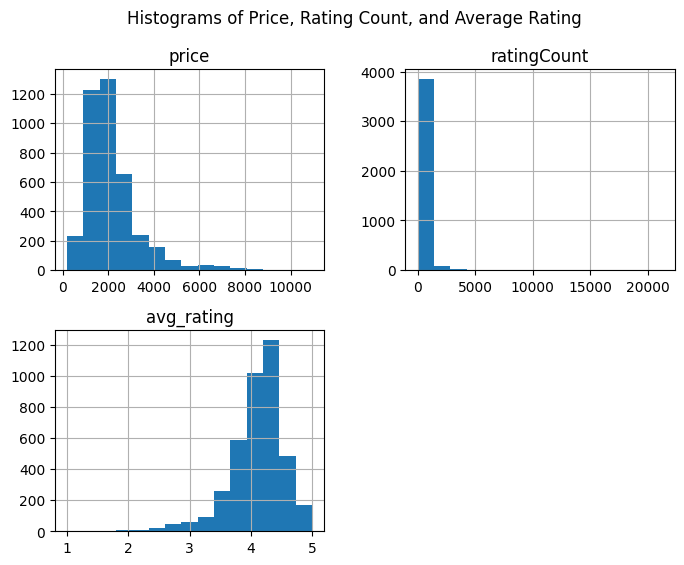

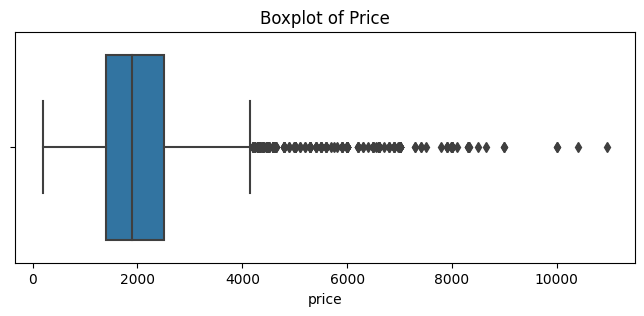

In [13]:
# Histograms for specific numerical data
fashion_data[['price', 'ratingCount', 'avg_rating']].hist(bins=15, figsize=(8, 6))
plt.suptitle("Histograms of Price, Rating Count, and Average Rating")  # Title for the entire figure
plt.show()

# Boxplot for the 'price' column to check for outliers
plt.figure(figsize=(8, 3))  # Optional: adjust figure size
sns.boxplot(data=fashion_data, x='price')
plt.title("Boxplot of Price")  # Title for the boxplot
plt.show()

<span style="color: navy;">

### Observation

- Speard of Price, rating_count and rating observed
- The box plot shows price variations, and median concentration.

</span>


In [14]:
#  Lets check description of the first item in the fashion DataFrame.
fashion_data.description[5]

"Stately and versatile, this kurta set will be your top choice. Its eye-catching printed kurta comes with snug printed palazzos and a gorgeous printed dupatta for added appeal. <br><br><b>Kurta design: </b><ul><li>Floral printed</li><li>Anarkali shape</li><li>Pleated style</li><li>Keyhole neck, three-quarter regular sleeves</li><li>Gotta patti detail</li><li>Calf length with flared hem</li><li>Pure cotton machine weave fabric</li></ul><b>Palazzos design: </b><ul><li>Printed Palazzos</li><li>Partially elasticated waistband</li><li>Slip-on closure</li><li>2 pockets</li></ul><b>Dupatta Design</b><br>Printed dupatta<br>Top fabric:  Pure Cotton <br> Bottom fabric:  Pure Cotton <br> Dupatta fabric:  Pure Cotton <br> Machine washThe model (height 5'8) is wearing a size S"

<span style="color: navy;">

### Observation

- A significant cleanup is required as product descriptions contains many HTML tags. 
- These HTML tags need to be removed to ensure the descriptions are clean and useful for search queries and analysis.
- While creating embedding, we dont want the processor to process those HTML tags, which will add no value
    

</span>


In [15]:
# Function to eliminate HTML tags from a given string.
def clean_html_tags(html_string):
    # Define a regular expression pattern to identify HTML tags.
    pattern = re.compile(r'<.*?>')

    # Replace HTML tags with spaces using the pattern.
    cleaned_string = re.sub(pattern, ' ', html_string)
    
    # Remove extra spaces: split the string into words, filter out empty elements, and rejoin into a single string.
    cleaned_string = cleaned_string.split(' ')
    cleaned_string = list(filter(None, cleaned_string))
    cleaned_string = " ".join(cleaned_string)
    
    # Return the cleaned string without HTML tags.
    return cleaned_string

In [16]:
# Validate if function worked
clean_html_tags(fashion_data.description[5])

"Stately and versatile, this kurta set will be your top choice. Its eye-catching printed kurta comes with snug printed palazzos and a gorgeous printed dupatta for added appeal. Kurta design: Floral printed Anarkali shape Pleated style Keyhole neck, three-quarter regular sleeves Gotta patti detail Calf length with flared hem Pure cotton machine weave fabric Palazzos design: Printed Palazzos Partially elasticated waistband Slip-on closure 2 pockets Dupatta Design Printed dupatta Top fabric: Pure Cotton Bottom fabric: Pure Cotton Dupatta fabric: Pure Cotton Machine washThe model (height 5'8) is wearing a size S"

<span style="color: navy;">

### Observation

- These HTML tags were removed and now the descriptions are clean and useful for search queries and analysis.

</span>

In [17]:
# Apply the remove_html_tags function to the 'description' column
# to remove HTML tags and create a new column 'cleaned_description' in the fashion DataFrame.

fashion_data['cleaned_description'] = fashion_data['description'].apply(lambda x: clean_html_tags(x))

# Display the first few rows of the modified DataFrame.
fashion_data.head(3)

p_id  \
0  17048614   
1  16524740   
2  16331376   

                                                                              name  \
0   Khushal K Women Black Ethnic Motifs Printed Kurta with Palazzos & With Dupatta   
1            InWeave Women Orange Solid Kurta with Palazzos & Floral Print Dupatta   
2  Anubhutee Women Navy Blue Ethnic Motifs Embroidered Thread Work Kurta with T...   

                                products   price     colour      brand  \
0               Kurta, Palazzos, Dupatta  5099.0      Black  Khushal K   
1  Kurta, Palazzos, Floral Print Dupatta  5899.0     Orange    InWeave   
2               Kurta, Trousers, Dupatta  4899.0  Navy Blue  Anubhutee   

   ratingCount  avg_rating  \
0       4522.0    4.418399   
1       1081.0    4.119334   
2       1752.0    4.161530   

                                                                       description  \
0  Black printed Kurta with Palazzos with dupatta <br> <br> <b> Kurta design:  ...   
1  Orange solid Kurta with Palazzos with dupatta<br><br><b>Kurta design: </b><u...   
2  Navy blue embroidered Kurta with Trousers with dupatta <br> <br> <b> Kurta d...   

                                                                      p_attributes  \
0  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,324,424', 'Body or Garment Size'...   
1  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,324,424', 'Body or Garment Size'...   
2  {'Add-Ons': 'NA', 'Body Shape ID': '333,424', 'Body or Garment Size': 'Garme...   

                                                               cleaned_description  
0  Black printed Kurta with Palazzos with dupatta Kurta design: Ethnic motifs p...  
1  Orange solid Kurta with Palazzos with dupatta Kurta design: Solid A-line sha...  
2  Navy blue embroidered Kurta with Trousers with dupatta Kurta design: Ethnic ...

<span style="color: navy;">

### Observation

- These HTML tags were removed in entire DF and now the descriptions are clean and useful for search queries and analysis.

</span>


<span style="color: navy;">


# Understanding Product Attributes Column

In [18]:
# The purpose of this code is to extract and process unique attributes from the 'p_attributes' column of the fashion_data 
# DataFrame.
# The code converts the 'p_attributes' column from JSON strings to dictionaries, extracts unique keys, and organizes 
# them into a new DataFrame.

# Set display options to show all columns and rows in the DataFrame

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)


# Make a copy of the DataFrame to work with as a temporary DataFrame
temp_df = fashion_data.copy()

# Converting the 'p_attributes' column to dictionaries in the temp DataFrame
temp_df['p_attributes_dict'] = temp_df['p_attributes'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else {})

# Extract all unique keys from the dictionaries
all_keys = []
for d in temp_df['p_attributes_dict']:
    all_keys.extend(d.keys())
all_keys = list(set(all_keys))  # Remove duplicates by converting to a set and back to a list

# Create a list to hold the rows for the new DataFrame
rows = []

# Populate the list with corresponding values
for _, d in temp_df.iterrows():
    row = {key: d['p_attributes_dict'].get(key, 'NA') for key in all_keys}
    rows.append(row)

# Create the new DataFrame from the list of rows
new_df = pd.DataFrame(rows, columns=all_keys)

# Transpose the DataFrame
transposed_df = new_df.transpose()

# Concatenate unique values for each key, ignoring 'NA'
transposed_df = transposed_df.apply(lambda x: ', '.join(set(x[x != 'NA'])), axis=1)

# Convert the Series back to a DataFrame
transposed_df = transposed_df.reset_index()
transposed_df.columns = ['Attribute', 'Values']

# Display the transposed DataFrame
transposed_df.head(150)


Attribute  \
0                                                   Stretch   
1                                                  Top Type   
2                                            Dupatta Fabric   
3                                                   Hemline   
4                                                Reversible   
5                                               Top Hemline   
6                                      Body or Garment Size   
7                                                Technology   
8                                                Sport Team   
9                                               Bottom Type   
10                                            Multipack Set   
11                                           Sleeve Styling   
12                                                Character   
13                                                Waistband   
14                                           Design Styling   
15                                               Top Length   
16                                                Sub Trend   
17                                              Care for me   
18                                           Bottom Pattern   
19                                                 Fly Type   
20                                                  Effects   
21                                               Top Fabric   
22                                              Fabric Type   
23                                              Top Pattern   
24                                       Top Design Styling   
25                                                   Length   
26                                                     Neck   
27                                          Dupatta Pattern   
28                                                  Closure   
29                                          Surface Styling   
30                                            Weave Pattern   
31                                                Technique   
32                                                Style Tip   
33                                           Brand Fit Name   
34                                                 Features   
35                                                   Trends   
36                                           Bottom Closure   
37                                                     Type   
38                                            Knit or Woven   
39                                            Colour Family   
40                                        Center Front Open   
41                                                      Fit   
42                                              Slit Detail   
43                                              taxMaterial   
44                                            Bottom Fabric   
45                                                 Fabric 3   
46                                                    Sport   
47                                                  Add-Ons   
48                                             Transparency   
49                                                  Dupatta   
50                                        Number of Pockets   
51                                          Collection Name   
52                                                    Shape   
53                                            Where-to-wear   
54                                            Sleeve Length   
55                                               Weave Type   
56                                            Ornamentation   
57                                                  Wedding   
58                                                Wash Care   
59                               How to care for your denim   
60                                                 Occasion   
61                                                 Fabric 2   
62                                                    Shade   
63                

<span style="color: navy;">

### Observation

- The purpose of above code was to check various attributes of each row level data, present in p_attribute col.
- Observed that lots of informative data is present in key value format, although, the col itself is object type, but data is dict type.
- This info will help during result evaluation / query prompt checking
   


</span>


<span style="color: navy;">


    
### **Product_Assortment Overview**

Currently, the product data is dispersed across multiple columns, which complicates the process of conducting comprehensive keyword searches.

This dispersion is particularly challenging as our focus is on document-based queries, which limits our search capabilities.

**Proposed Solutions:**

- **Option 1:** Centralize all product information into a single metadata repository. Develop a chatbot that can extract these metadata values to enable precise filtering. The results from this filtering would then be used to build a RAG (Retrieval-Augmented Generation) model, enhancing search functionality.

- **Option 2:** Create a unified document, referred to as a 'Product_Assortment', that includes all product details. This document would be fully integrated into the document section of the vector database, ensuring that the database recognizes additional keywords present in user queries.

For this specific task, **Option 2** was chosen due to its superior efficiency in handling search operations.

</span>


In [19]:
def generate_product_assortment(product):

    # Format the product details into a readable string, excluding non-significant fields.
    product_assortment_details = f"""
    Name : {product['name']}
    Products : {product['products']}
    Price : {product['price']}
    Color : {product['colour']}
    Brand : {product['brand']} 
    Average Rating : {f"{product['avg_rating']:.2f}"} 
    Product Description : {product['cleaned_description']}
    Product Attributes : {product['p_attributes']}
    
    """
    
    return product_assortment_details.strip()

In [20]:
# An example product_assortment
print(generate_product_assortment(fashion_data.iloc[52]))

Name : Ahalyaa Women Black Floral Pleated Pure Cotton Kurti with Trousers
    Products : Kurti, Trousers
    Price : 5500.0
    Color : Black
    Brand : Ahalyaa 
    Average Rating : 3.18 
    Product Description : Black solid Kurti with Trousers Kurti design: Floral solid Pathani shape Pleated style Shirt collar, three-quarter roll-up sleeves 1 pockets Calf length with curved hem Pure cotton machine weave fabric Trousers design: Printed Trousers Partially elasticated waistband Hand Wash The model (height 5'8) is wearing a size S
    Product Attributes : {'Add-Ons': 'NA', 'Body Shape ID': '333,424', 'Body or Garment Size': 'Garment Measurements in', 'Bottom Closure': 'NA', 'Bottom Fabric': 'Pure Cotton', 'Bottom Pattern': 'Printed', 'Bottom Type': 'Trousers', 'Character': 'NA', 'Dupatta': 'NA', 'Dupatta Border': 'Taping', 'Dupatta Fabric': 'NA', 'Dupatta Pattern': 'Printed', 'Main Trend': 'NA', 'Neck': 'Shirt Collar', 'Number of Pockets': '1', 'Occasion': 'Festive', 'Ornamentation': '

In [21]:
pd.set_option('display.max_colwidth', 80)

# Generate a product_assortment for each product in the fashion DataFrame using the generate_product_assortment function.
fashion_data['product_assortment'] = fashion_data.apply(generate_product_assortment, axis=1)

# Calculate the length of each product_assortment string and store this in a new column 'product_assortment_len'.
fashion_data['product_assortment_len'] = fashion_data['product_assortment'].apply(len)

# Display the initial few rows of the updated DataFrame to verify changes.
fashion_data.head(3)

p_id  \
0  17048614   
1  16524740   
2  16331376   

                                                                              name  \
0   Khushal K Women Black Ethnic Motifs Printed Kurta with Palazzos & With Dupatta   
1            InWeave Women Orange Solid Kurta with Palazzos & Floral Print Dupatta   
2  Anubhutee Women Navy Blue Ethnic Motifs Embroidered Thread Work Kurta with T...   

                                products   price     colour      brand  \
0               Kurta, Palazzos, Dupatta  5099.0      Black  Khushal K   
1  Kurta, Palazzos, Floral Print Dupatta  5899.0     Orange    InWeave   
2               Kurta, Trousers, Dupatta  4899.0  Navy Blue  Anubhutee   

   ratingCount  avg_rating  \
0       4522.0    4.418399   
1       1081.0    4.119334   
2       1752.0    4.161530   

                                                                       description  \
0  Black printed Kurta with Palazzos with dupatta <br> <br> <b> Kurta design:  ...   
1  Orange solid Kurta with Palazzos with dupatta<br><br><b>Kurta design: </b><u...   
2  Navy blue embroidered Kurta with Trousers with dupatta <br> <br> <b> Kurta d...   

                                                                      p_attributes  \
0  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,324,424', 'Body or Garment Size'...   
1  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,324,424', 'Body or Garment Size'...   
2  {'Add-Ons': 'NA', 'Body Shape ID': '333,424', 'Body or Garment Size': 'Garme...   

                                                               cleaned_description  \
0  Black printed Kurta with Palazzos with dupatta Kurta design: Ethnic motifs p...   
1  Orange solid Kurta with Palazzos with dupatta Kurta design: Solid A-line sha...   
2  Navy blue embroidered Kurta with Trousers with dupatta Kurta design: Ethnic ...   

                                                                product_assortment  \
0  Name : Khushal K Women Black Ethnic Motifs Printed Kurta with Palazzos & Wit...   
1  Name : InWeave Women Orange Solid Kurta with Palazzos & Floral Print Dupatta...   
2  Name : Anubhutee Women Navy Blue Ethnic Motifs Embroidered Thread Work Kurta...   

   product_assortment_len  
0                    1717  
1                    1688  
2                    1707

<span style="color: navy;">

### Observation

- Comprehensive Formatting: generate_product_assortment function compiles essential product details such as name, category, price, color, brand, rating, description, and attributes into a single formatted string.
- Exclusion of Non-Significant Fields: Fields deemed non-essential for search relevance, such as 'ratingCount' and 'p_id', are excluded from the formatted string.
- Enhanced Readability: The formatted string enhances readability by clearly presenting product information, which is crucial for generating meaningful search results and recommendations.
- generate_product_assortment has been sucessfully applied at DF level and product_assortment and product_assortment_len cols created
   


</span>


In [22]:
# Check descriptive statistics for the 'product_assortment_len' column in the fashion DataFrame,
fashion_data['product_assortment_len'].describe(percentiles=[0.99]).round()

count    4000.0
mean     1131.0
std       320.0
min       527.0
50%      1047.0
99%      2072.0
max      2813.0
Name: product_assortment_len, dtype: float64

<span style="color: navy;">

### Observation    
    
- The data indicates that the maximum sentence length is 2,813 and the maximum length within 99% of the portfolio entries is 2,072.
- Upon further research, we discovered the model **text-embedding-ada-002** from OpenAI, which has a maximum input length of 8,191 tokens. This model has been optimized for a variety of text embedding tasks and supports large text lengths, making it suitable for our current needs.
- Therefore, chunking of individual product descriptions into smaller segments is not necessary for this model.

### Prepare Metadata
- To facilitate the display of product images, we will create metadata containing only the 'p_id' value.

### Generate and Store Embeddings
- In this step, we will utilize the **text-embedding-ada-002** model through the SentenceTransformer framework to embed the product descriptions. The resulting embeddings will be stored in a ChromaDB collection, leveraging its efficient handling of vector data for quick retrieval based on similarity.


</span>


In [23]:
# Function to generate metadata 'p_id' for the given product data.
def prepare_metadata(data):
    # Create a dictionary with 'p_id' as the metadata key & the corresponding value.
    metadata = {
        'p_id': data['p_id']
    }
    return metadata

In [24]:
# Create metadata entries for each product in the fashion DataFrame using the prepare_metadata function, 
# and save them in a new column named 'Metadata'.
fashion_data['Metadata'] = fashion_data.apply(prepare_metadata, axis=1)

# Display the first few rows of the modified DataFrame.
fashion_data.head(2)

p_id  \
0  17048614   
1  16524740   

                                                                             name  \
0  Khushal K Women Black Ethnic Motifs Printed Kurta with Palazzos & With Dupatta   
1           InWeave Women Orange Solid Kurta with Palazzos & Floral Print Dupatta   

                                products   price  colour      brand  \
0               Kurta, Palazzos, Dupatta  5099.0   Black  Khushal K   
1  Kurta, Palazzos, Floral Print Dupatta  5899.0  Orange    InWeave   

   ratingCount  avg_rating  \
0       4522.0    4.418399   
1       1081.0    4.119334   

                                                                       description  \
0  Black printed Kurta with Palazzos with dupatta <br> <br> <b> Kurta design:  ...   
1  Orange solid Kurta with Palazzos with dupatta<br><br><b>Kurta design: </b><u...   

                                                                      p_attributes  \
0  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,324,424', 'Body or Garment Size'...   
1  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,324,424', 'Body or Garment Size'...   

                                                               cleaned_description  \
0  Black printed Kurta with Palazzos with dupatta Kurta design: Ethnic motifs p...   
1  Orange solid Kurta with Palazzos with dupatta Kurta design: Solid A-line sha...   

                                                                product_assortment  \
0  Name : Khushal K Women Black Ethnic Motifs Printed Kurta with Palazzos & Wit...   
1  Name : InWeave Women Orange Solid Kurta with Palazzos & Floral Print Dupatta...   

   product_assortment_len            Metadata  
0                    1717  {'p_id': 17048614}  
1                    1688  {'p_id': 16524740}

<span style="color: navy;">


# Store in Chroma DB

In [25]:
# Read the API key from a file
with open('/kaggle/input/openai-api-key/OpenAI_API_Key.txt', 'r') as file:
    api_key = file.read().strip()

# Create an instance of the OpenAIEmbeddingFunction class, specifying the model name "text-embedding-ada-002"
# to use the pre-trained model from OpenAI.
model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=api_key, model_name=model)

# Initialize the PersistentClient to store the database locally and reuse resources.
client = chromadb.PersistentClient()

# Get or create a collection named 'Fashion_Data_Main_Chroma_DB' in Chroma using the client.
# Associate the embedding_function with the collection to use OpenAI embeddings for document embedding.
all_fashion_info = client.get_or_create_collection(name='Fashion_Data_Main_Chroma_DB', embedding_function=embedding_function)

# Convert the 'product_assortment' column from the fashion DataFrame to a list of documents.
documents_list = fashion_data["product_assortment"].tolist()

# Convert the 'Metadata' column from the fashion DataFrame to a list of metadata.
metadata_list = fashion_data['Metadata'].tolist()

# Generate a list of IDs for the documents.
ids = [str(i) for i in range(len(documents_list))]

# Display a few items to confirm everything is working
print(f"First 5 from API Key: {api_key[:5]}...")  # Just to confirm the API key was read (only print the first 5 characters for security)
print("")
print("Sample Documents List:\n", documents_list[:2])
print("")
print("Sample Metadata List:\n", metadata_list[:2])
print("")
print("Sample IDs:\n", ids[:2])

First 5 from API Key: sk-OT...

Sample Documents List:
 ["Name : Khushal K Women Black Ethnic Motifs Printed Kurta with Palazzos & With Dupatta\n    Products : Kurta, Palazzos, Dupatta\n    Price : 5099.0\n    Color : Black\n    Brand : Khushal K \n    Average Rating : 4.42 \n    Product Description : Black printed Kurta with Palazzos with dupatta Kurta design: Ethnic motifs printed Anarkali shape Regular style Mandarin collar, three-quarter regular sleeves Calf length with flared hem Viscose rayon machine weave fabric Palazzos design: Printed Palazzos Elasticated waistband Slip-on closure Dupatta Length 2.43 meters Width:&nbsp;88 cm The model (height 5'8) is wearing a size S100% Rayon Machine wash\n    Product Attributes : {'Add-Ons': 'NA', 'Body Shape ID': '443,333,324,424', 'Body or Garment Size': 'Garment Measurements in', 'Bottom Closure': 'Slip-On', 'Bottom Fabric': 'Viscose Rayon', 'Bottom Pattern': 'Printed', 'Bottom Type': 'Palazzos', 'Character': 'NA', 'Dupatta': 'With Dupatt

<span style="color: navy;">

### Observation    
    
-  Info via print statement looks all good and as expected.
-  We can now populate same in Chroma DB vector DB.
    


In [26]:
# Add documents to the collection with a tqdm progress bar.
# Use tqdm to iterate over each document, along with its corresponding metadata and ID.
for doc, doc_metadata, doc_id in tqdm(zip(documents_list, metadata_list, ids), desc='Now adding documents and meta to Fashion_Data_Main_Chroma_DB', total=len(documents_list)):
    # Add the current document to the collection.
    all_fashion_info.add(
        documents=[doc],
        ids=[doc_id],
        metadatas=[doc_metadata])

Now adding documents and meta to Fashion_Data_Main_Chroma_DB: 100%|██████████| 4000/4000 [22:14<00:00,  3.00it/s]


In [119]:
# Let's take a look at the first few entries in the collection
all_fashion_info.get(
    ids = ['0','1','2'],
    include = ['documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': None,
 'metadatas': [{'p_id': 17048614}, {'p_id': 16524740}, {'p_id': 16331376}],
 'documents': ["Name : Khushal K Women Black Ethnic Motifs Printed Kurta with Palazzos & With Dupatta\n    Products : Kurta, Palazzos, Dupatta\n    Price : 5099.0\n    Color : Black\n    Brand : Khushal K \n    Average Rating : 4.42 \n    Product Description : Black printed Kurta with Palazzos with dupatta Kurta design: Ethnic motifs printed Anarkali shape Regular style Mandarin collar, three-quarter regular sleeves Calf length with flared hem Viscose rayon machine weave fabric Palazzos design: Printed Palazzos Elasticated waistband Slip-on closure Dupatta Length 2.43 meters Width:&nbsp;88 cm The model (height 5'8) is wearing a size S100% Rayon Machine wash\n    Product Attributes : {'Add-Ons': 'NA', 'Body Shape ID': '443,333,324,424', 'Body or Garment Size': 'Garment Measurements in', 'Bottom Closure': 'Slip-On', 'Bottom Fabric': 'Viscose Rayon', 'Bottom Pattern': 

<span style="color: navy;">

### Observation    
    
-  Used Get method to sample check from Chroma DB
-  Result looks as expected
    


<span style="color: navy;">

# 2.1 Implement query from either cache or main collection

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

In [120]:
# Set up a cache collection named 'Fashion_Data_Cache_Chroma_DB' in Chroma using the client.
# Associate the existing embedding_function with the collection for document embedding.
cache_collection = client.get_or_create_collection(name='Fashion_Data_Cache_Chroma_DB', embedding_function=embedding_function)

# Define a threshold value for cache search to control the similarity threshold.
threshold = 0.2

In [121]:
def query_from_main_or_cache_collection(query):
    # Initialize lists and DataFrame to store query results
    ids = []
    documents = []
    distances = []
    metadatas = []
    results_df = pd.DataFrame()

    # Search the cache collection first
    cache_results = cache_collection.query(
        query_texts=query,
        n_results=1
    )

    # If the cache is empty or the distance exceeds the threshold, query the main collection
    if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
        # Query the main collection and return the top 10 results
        results = all_fashion_info.query(
            query_texts=query,
            n_results=8
        )

        # Store the query in the cache collection as a document for future reference
        # Store retrieved text, ids, distances, and metadatas in cache_collection for easy retrieval
        keys = []
        values = []
        for key, val in results.items():
            if val is None:
                continue
            for i in range(8):
                keys.append(str(key) + str(i))
                values.append(str(val[0][i]))

        cache_collection.add(
             documents=[query],
            ids=[query],
            metadatas=dict(zip(keys, values))
        )

        print("[NOTE] : Not found in cache. Found in main collection.")
        print(" ")
        print("User query : ",query)

        # Construct DataFrame from query results
        result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0],
                       'Distances': results['distances'][0], "IDs": results["ids"][0]}
        results_df = pd.DataFrame.from_dict(result_dict)

    # If the distance is within the threshold, return the results from cache
    elif cache_results['distances'][0][0] <= threshold:
        cache_result_dict = cache_results['metadatas'][0][0]

        # Extract data from cache result dictionary
        for key, value in cache_result_dict.items():
            if 'ids' in key:
                ids.append(value)
            elif 'documents' in key:
                documents.append(value)
            elif 'distances' in key:
                distances.append(value)
            elif 'metadatas' in key:
                metadatas.append(value)

        print("[NOTE] : Found in cache!")
        print(" ")
        print("User query : ",query)

        # Create DataFrame from cache query results
        results_df = pd.DataFrame({
            'IDs': ids,
            'Documents': documents,
            'Distances': distances,
            'Metadatas': metadatas
        })

    return results_df

In [124]:
# Read the sample user query
# User query can also be taken using query = input() , however, for testing purpose, query is provided as string input directly.
# Suggest me Palazzos with max price as 2500 rupess and I prefer blue color with Floral pattern
query = input() 

 Suggest me Palazzos with max price as 2500 rupess and I prefer blue color with Floral pattern


In [125]:
pd.set_option('display.max_colwidth', None)

# Query the main or cache collection based on the input query
results_df = query_from_main_or_cache_collection(query)

# Display the query results DataFrame
results_df

[NOTE] : Not found in cache. Found in main collection.
 
User query :  Suggest me Palazzos with max price as 2500 rupess and I prefer blue color with Floral pattern


Metadatas  \
0  {'p_id': 15097110}   
1  {'p_id': 17644444}   
2  {'p_id': 11305458}   
3  {'p_id': 14177888}   
4  {'p_id': 17307508}   
5  {'p_id': 14370150}   
6  {'p_id': 17154750}   
7  {'p_id': 13951522}   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Documents  \
0                                                                                                                                                                                                                                                                                                             Name : Rajnandini Women Blue & Off White Floral Printed Flared Handloom Palazzos\n    Products : Palazzos\n    Price : 1663.0\n    Color : Blue\n    Brand : Rajnandini \n    Average Rating : 4.33 \n    Product Description : Blue and off white handloom palazzos Floral printed Opaque Flared fit Elasticated waistband Length: regular Handloom cotton fabric Cotton Hand washFlared fit The model (height 5'8) is wearing a size S\n    Product Attributes : {'Body or Garment Size': 'To-Fit Denotes Body Measurements in', 'Care for me': 'Hand Wash', 'Closure': 'Drawstring', 'Fabric': 'Cotton', 'Fabric 2': 'NA', 'Fit': 'Flared', 'Length': 'Regular', 'Main Trend': 'Indie Prints', 'Multipack Set': 'Single', 'Number of Pockets': '2', 'Occasion': 'Western', 'Pattern': 'Printed', 'Print or Pattern Type': 'Floral', 'Sustainable': 'Regular', 'Transparency': 'Opaque', 'Waistband': 'Elasticated', 'Wash Care': 'Hand Wash', 'Weave Type': 'Handloom'}   
1                                                                                                                                                                                                                                                                                                                                                      Name : Libas Women Blue Floral Printed Ethnic Palazzos\n    Products : Palazzos\n    Price : 1399.0\n    Color : Blue\n    Brand : Libas \n    Average Rating : 4.75 \n    Product Description : Blue woven palazzos Floral printed Opaque Straight fit Partially elasticated waistband Length: regular Woven silk fabric Gentle Machine Wash Straight fit The model (height 5'8) is wearing a size S\n    Product Attributes : {'Body or Garment Size': 'To-Fit Denotes Body Measurements in', 'Care for me': 'NA', 'Closure': 'Slip-On', 'Fabric': 'Silk', 'Fabric 2': 'Blended', 'Fit': 'Straight', 'Length': 'Regular', 'Main Trend': 'NA', 'Multipack Set': 'Single', 'Number of Pockets': '2', 'Occasion': 'Ethnic', 'Pattern': 'Printed', 'Print or Pattern Type': 'Floral', 'Sustainable': 'Regular', 'Transparency': 'Opaque', 'Waistband': 'Partially Elasticated', 'Wash Care': 'Machine Wash', 'Weave Type': 'Woven'}   
2                                                     

<span style="color: navy;">

### Observation    
    
-  Top 8 results matching user query retrived from Chroma DB
-  Results are sorted on Distances col.     

    

<span style="color: navy;">

## 2.2 Re-Ranking with a Cross Encoder

Re-ranking the results obtained from semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.



In [127]:
# Initialize the cross encoder model with the 'ms-marco-MiniLM-L-6-v2'
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

In [128]:
# Create input (query, response) pairs for the top 8 responses from the semantic search to be used with the cross encoder.

# Prepare input pairs for cross-encoder prediction by combining the query with each response from the results DataFrame.
cross_inputs = [[query, response] for response in results_df['Documents']]

# Use the cross encoder to predict scores for each query-response pair.
cross_rerank_scores = cross_encoder.predict(cross_inputs)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [129]:
print("User query : ",query)
print(" ")

# Store the reranked scores in the results DataFrame under the column 'Reranked_scores'.
results_df['Reranked_scores'] = cross_rerank_scores

# Display the updated results DataFrame.
results_df

User query :  Suggest me Palazzos with max price as 2500 rupess and I prefer blue color with Floral pattern
 


Metadatas  \
0  {'p_id': 15097110}   
1  {'p_id': 17644444}   
2  {'p_id': 11305458}   
3  {'p_id': 14177888}   
4  {'p_id': 17307508}   
5  {'p_id': 14370150}   
6  {'p_id': 17154750}   
7  {'p_id': 13951522}   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Documents  \
0                                                                                                                                                                                                                                                                                                             Name : Rajnandini Women Blue & Off White Floral Printed Flared Handloom Palazzos\n    Products : Palazzos\n    Price : 1663.0\n    Color : Blue\n    Brand : Rajnandini \n    Average Rating : 4.33 \n    Product Description : Blue and off white handloom palazzos Floral printed Opaque Flared fit Elasticated waistband Length: regular Handloom cotton fabric Cotton Hand washFlared fit The model (height 5'8) is wearing a size S\n    Product Attributes : {'Body or Garment Size': 'To-Fit Denotes Body Measurements in', 'Care for me': 'Hand Wash', 'Closure': 'Drawstring', 'Fabric': 'Cotton', 'Fabric 2': 'NA', 'Fit': 'Flared', 'Length': 'Regular', 'Main Trend': 'Indie Prints', 'Multipack Set': 'Single', 'Number of Pockets': '2', 'Occasion': 'Western', 'Pattern': 'Printed', 'Print or Pattern Type': 'Floral', 'Sustainable': 'Regular', 'Transparency': 'Opaque', 'Waistband': 'Elasticated', 'Wash Care': 'Hand Wash', 'Weave Type': 'Handloom'}   
1                                                                                                                                                                                                                                                                                                                                                      Name : Libas Women Blue Floral Printed Ethnic Palazzos\n    Products : Palazzos\n    Price : 1399.0\n    Color : Blue\n    Brand : Libas \n    Average Rating : 4.75 \n    Product Description : Blue woven palazzos Floral printed Opaque Straight fit Partially elasticated waistband Length: regular Woven silk fabric Gentle Machine Wash Straight fit The model (height 5'8) is wearing a size S\n    Product Attributes : {'Body or Garment Size': 'To-Fit Denotes Body Measurements in', 'Care for me': 'NA', 'Closure': 'Slip-On', 'Fabric': 'Silk', 'Fabric 2': 'Blended', 'Fit': 'Straight', 'Length': 'Regular', 'Main Trend': 'NA', 'Multipack Set': 'Single', 'Number of Pockets': '2', 'Occasion': 'Ethnic', 'Pattern': 'Printed', 'Print or Pattern Type': 'Floral', 'Sustainable': 'Regular', 'Transparency': 'Opaque', 'Waistband': 'Partially Elasticated', 'Wash Care': 'Machine Wash', 'Weave Type': 'Woven'}   
2                                                     

In [130]:
print("User query : ",query)
print(" ")
    

# Sort the results DataFrame by 'Reranked_scores' in descending order and select the top 3 entries.
top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)[:3]

# Display the top 3 reranked entries.
top_3_rerank


User query :  Suggest me Palazzos with max price as 2500 rupess and I prefer blue color with Floral pattern
 


Metadatas  \
1  {'p_id': 17644444}   
3  {'p_id': 14177888}   
0  {'p_id': 15097110}   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    Documents  \
1                                           Name : Libas Women Blue Floral Printed Ethnic Palazzos\n    Products : Palazzos\n    Price : 1399.0\n    Color : Blue\n    Brand : Libas \n    Average Rating : 4.75 \n    Product Description : Blue woven palazzos Floral printed Opaque Straight fit Partially elasticated waistband Length: regular Woven silk fabric Gentle Machine Wash Straight fit The model (height 5'8) is wearing a size S\n    Product Attributes : {'Body or Garment Size': 'To-Fit Denotes Body Measurements in', 'Care for me': 'NA', 'Closure': 'Slip-On', 'Fabric': 'Silk', 'Fabric 2': 'Blended', 'Fit': 'Straight', 'Length': 'Regular', 'Main Trend': 'NA', 'Multipack Set': 'Single', 'Number of Pockets': '2', 'Occasion': 'Ethnic', 'Pattern': 'Printed', 'Print or Pattern Type': 'Floral', 'Sustainable': 'Regular', 'Transparency': 'Opaque', 'Waistband': 'Partially Elasticated', 'Wash Care': 'Machine Wash', 'Weave Type': 'Woven'}   
3                                                                 Name : KLOTTHE Women Blue & White Floral Printed Flared Cropped Palazzos\n    Products : Palazzos\n    Price : 2499.0\n    Color : Blue\n    Brand : KLOTTHE \n    Average Rating : 2.71 \n    Product Description : A pair of Blue and White printed woven flared fit Palazzos, opaque, 2 pockets, and slip-on closureMaterial: Polycotton Machine WashThe model (height 5'8") is wearing a size 28\n    Product Attributes : {'Body or Garment Size': 'To-Fit Denotes Body Measurements in', 'Closure': 'Slip-On', 'Fabric': 'Polycotton', 'Fabric 2': 'NA', 'Fit': 'Flared', 'Length': 'Cropped', 'Main Trend': 'NA', 'Multipack Set': 'Single', 'Number of Pockets': '2', 'Occasion': 'Western', 'Pattern': 'Printed', 'Print or Pattern Type': 'Floral', 'Sustainable': 'Regular', 'Transparency': 'Opaque', 'Waistband': 'Partially Elasticated', 'Wash Care': 'Machine Wash', 'Weave Type': 'Woven'}   
0  Name : Rajnandini Women Blue & Off White Floral Printed Flared Handloom Palazzos\n    Products : Palazzos\n    Price : 1663.0\n    Color : Blue\n    Brand : Rajnandini \n    Average Rating : 4.33 \n    Product Description : Blue and off white handloom palazzos Floral printed Opaque Flared fit Elasticated waistband Length: regular Handloom cotton fabric Cotton Hand washFlared fit The model (height 5'8) is wearing a size S\n    Product Attributes : {'Body or Garment Size': 'To-Fit Denotes Body Measurements in', 'Care for me': 'Hand Wash', 'Closure': 'Drawstring', 'Fabric': 'Cotton', 'Fabric 2': 'NA', 'Fit': 'Flared', 'Length': 'Regular', 'Main Trend': 'Indie Prints', 'Multipack Set': 'Single', 'Number of Pockets': '2', 'Occasion': 'Western', 'Pattern': 'Printed', 'Print or Pattern Type': 'Floral', 'Sustainable': 'Regular', 'Transparency': 'Opaque', 'Waistband': 'Elasticated', 'Wash Care': 'Hand Wash', 'Weave Type': 'Handloom'}   

   Distances   IDs  Reranked_scores  
1   0.285889  2813         0.168023  
3   0.303060  3087        -0.304450  
0   0.272573  30

<span style="color: navy;">

### Observation    
    
- Post re-rank the top 3 results looks as expected for user request. 
- Cross encoder has rightly ranked scores 
    

<span style="color: navy;">

## 2.3 Semantic Search with Re-ranking





In [131]:
def Semantic_Srch_With_Rerank(query=None, top_n=3):
    # Prompt the user to enter a query if not provided
    if query is None:
        query = input("Enter your query: ")
    
    print('Query:', query)
    print('*'*35 + '\n')

    # Query the main or cache collection based on the input query
    query_results_df = query_from_main_or_cache_collection(query)
    
    # Prepare inputs for cross-encoder prediction by pairing the query with each response
    cross_inputs = [[query, response] for response in query_results_df['Documents']]
    
    # Predict rerank scores using the cross encoder
    cross_rerank_scores = cross_encoder.predict(cross_inputs)
    
    # Store reranked scores in the results DataFrame
    query_results_df['Reranked_scores'] = cross_rerank_scores
    
    # Select the top n reranked entries
    top_n_rerank = query_results_df.sort_values(by='Reranked_scores', ascending=False).head(top_n)

    return top_n_rerank

In [132]:
# An example semantic search
Semantic_Srch_With_Rerank('Suggest me Printed Kurta set in magenta color')

Query: Suggest me Printed Kurta set in magenta color
***********************************

[NOTE] : Not found in cache. Found in main collection.
 
User query :  Suggest me Printed Kurta set in magenta color


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Metadatas  \
0  {'p_id': 18103376}   
1  {'p_id': 16022908}   
3  {'p_id': 16844454}   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Documents  \
0                                                                                                                                                                                          Name : IkDaiya Women Magenta Ethnic Motifs Printed Kurta with Trousers & With Dupatta\n    Products : Kurta, Trousers, Dupatta\n    Price : 4598.0\n    Color : Magenta\n    Brand : IkDaiya \n    Average Rating : 3.89 \n    Product Description : Magenta printed Kurta with Trousers with dupatta Kurta design: Ethnic motifs printed Straight shape Regular style Tie-up neck, long regular sleeves Calf length with straight hem Viscose rayon machine weave fabric Trousers design: Printed Trousers Elasticated waistband Zip closure Rayon Hand WashThe model (height 5'8) is wearing a size S\n    Product Attributes : {'Add-Ons': 'NA', 'Body Shape ID': '333,424', 'Body or Garment Size': 'Garment Measurements in', 'Bottom Closure': 'Zip', 'Bottom Fabric': 'Viscose Rayon', 'Bottom Pattern': 'Printed', 'Bottom Type': 'Trousers', 'Character': 'NA', 'Dupatta': 'With Dupatta', 'Dupatta Border': 'Taping', 'Dupatta Fabric': 'Poly Chiffon', 'Dupatta Pattern': 'Printed', 'Main Trend': 'NA', 'Neck': 'Tie-Up Neck', 'Number of Pockets': 'NA', 'Occasion': 'Fusion', 'Ornamentation': 'NA', 'Pattern Coverage': 'Small', 'Print or Pattern Type': 'Ethnic Motifs', 'Sleeve Length': 'Long Sleeves', 'Sleeve Styling': 'Regular Sleeves', 'Slit Detail': 'Side Slits', 'Stitch': 'Ready to Wear', 'Sustainable': 'Regular', 'Technique': 'NA', 'Top Design Styling': 'Regular', 'Top Fabric': 'Viscose Rayon', 'Top Hemline': 'Straight', 'Top Length': 'Calf Length', 'Top Pattern': 'Printed', 'Top Shape': 'Straight', 'Top Type': 'Kurta', 'Waistband': 'Elasticated', 'Wash Care': 'Machine Wash', 'Weave Pattern': 'Regular', 'Weave Type': 'Machine Weave', 'Wedding': 'NA'}   
1                                                                                                                                                                                                                                                      

<span style="color: navy;">

### Observation    
    
-  Semantic search with re-rank has suggested close match results as per user request

    

<span style="color: navy;">

## Layer 3 : Generative Search - Final touch
    
- With the final top semantic search results, refined through reranking, we can now utilize GPT-3.5. By combining these results with the user query and a carefully crafted prompt, we can generate a precise answer to the query instead of merely returning the stored results.


In [133]:
# Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
def generate_response(query, results_df):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
        {
            "role": "system",
            "content": "You are a fashion expert who can showcase a product in such a way that the user gets fully satisfied."
        },
        {
            "role": "user",
            "content": f"""
            You are a fashion expert who can showcase a product in such a way that the user gets fully satisfied.
            You have a question asked by the user: '{query}', and you have some search results from a corpus of fashion products database in the dataframe '{results_df}'. These search results are essentially products that may be relevant to the user query.
            
            The column 'documents' inside this dataframe contains the actual descriptions of the products.
            
            Use the documents in '{results_df}' to answer the query '{query}'. Frame an informative answer and also use the dataframe to return detailed product information.
            Additionally, use the data from 'Attributes' to provide an answer related to the query '{query}'.
            
            Follow these guidelines when performing the task:
            1. Provide relevant/accurate numbers if available.
            2. Use only the information that is relevant; you don’t have to use all the information in the dataframe.
            3. If you can't provide the complete answer, include a disclaimer.
            4. Avoid using keywords similar to 'database', 'results', 'search'.
            5. Do not start with a welcome note or end with a follow-up statement or question to avoid penalties.
            6. Prices info should be referred in INR.
            7. If user query contains rating, refer the closest match
            
            The generated response should directly address the query, avoiding unnecessary information.
            If the query is not relevant to the document, provide the best possible response.
            Ensure the final response is simple, clear, and naturally formatted for easy reading.
        """},
    ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    return response.choices[0].message.content.split('\n')


# Display image corresponding to a product result from the dataframe.
def display_product_image(result_df):
  
    # Extract metadata from the input result
    metadata_string = result_df['Metadatas']
    
    # Convert metadata string to dictionary and extract image number
    try:
        metadata_dict = ast.literal_eval(metadata_string)
        imgNo_string = str(metadata_dict['p_id'])
    except ValueError:
        imgNo_string = str(metadata_string['p_id'])
    
    # Construct the path to the image
    img_path = f"/kaggle/input/myntra-fashion-product-dataset/images/{imgNo_string}.jpg"
    
    # Display the image
    image = Image(img_path, width="200")
    display(image)

def print_response_and_display_product_image(result_df, response, result_text="Response:"):
    """
    Print the generated response and display the corresponding product image.
    """
    # Print the generated response
    print("\n" + "-" * 35)
    print(result_text)
    print("-" * 35)
    print("\n".join(response))
    print()

    # Display the image of the suggested product
    print("Hey, here's recommended product, specially for you :")
    display_product_image(result_df)


In [134]:
# Perform generative search by combining semantic search with reranking and generating a response.
def Generative_Search(query=None):
    # If query is not provided, prompt the user to input a query
    if query is None:
        query = input()
    
    # Perform semantic search with reranking to retrieve the top 3 most relevant results
    semantic_search_df = Semantic_Srch_With_Rerank(query, top_n=3)
    # Reset the index for proper iteration
    semantic_search_df = semantic_search_df.reset_index()

    for index, result in semantic_search_df.iterrows():
        if index == 0:
            # Generate a response based on the query and retrieved information
            response = generate_response(query, result[['Documents']])
            print_response_and_display_product_image(result_df=result, response=response, result_text="Top product")
        else:
            # Check if the current result is close to the previous result
            if abs(previous_rank_score - result['Reranked_scores']) <= 0.5:
                # Generate a response based on the query and retrieved information
                response = generate_response(query, result[['Documents']])
                print_response_and_display_product_image(result_df=result, response=response, result_text="Similar product")
            # If not close enough, break the loop and stop suggesting similar products
            else:
                break
        # Store the current rerank score to compare in the next cycle
        previous_rank_score = result['Reranked_scores']

Query: Suggest Printed Floral Anarkali Kurta, in black color, with average rating of above 4
***********************************

[NOTE] : Not found in cache. Found in main collection.
 
User query :  Suggest Printed Floral Anarkali Kurta, in black color, with average rating of above 4


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


-----------------------------------
Top product
-----------------------------------
The Glam Roots Women Black Floral Printed Anarkali Kurta is a stylish choice for those seeking a fashionable outfit. It features a floral print on black fabric, a round neck, three-quarter sleeves, and a flared hem. This Anarkali Kurta is made of regular cotton with a panelled design, making it a perfect blend of comfort and elegance.

With an average rating of 4.14, this kurta meets the criteria of having an above-average rating of over 4, ensuring its quality and satisfaction among customers. Priced at INR 1999, it offers great value for a trendy and well-rated piece.

The product attributes highlight its design elements such as its Anarkali shape, calf length, and floral print pattern. The use of pure cotton fabric with a regular weave type ensures a comfortable fit and easy maintenance with machine wash care.

In summary, the Glam Roots Black Floral Printed Anarkali Kurta is a premium choice for th

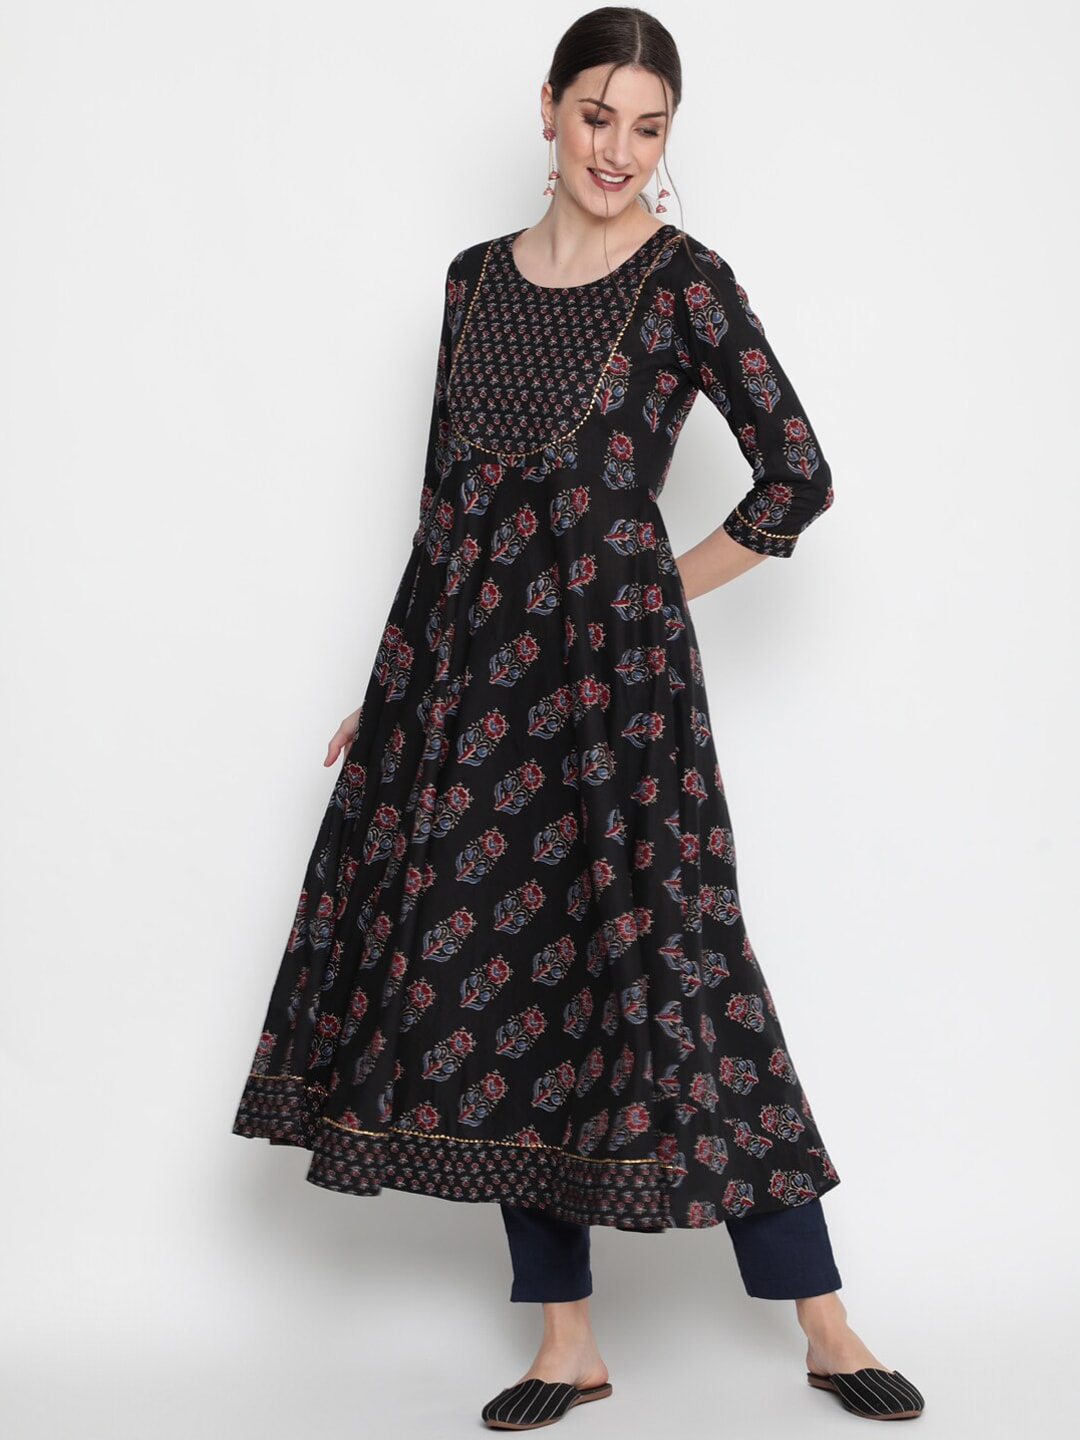


-----------------------------------
Similar product
-----------------------------------
This black Floral Anarkali Kurta by Jompers features a round neck, three-quarter sleeves, and a calf-length flared hem, perfect for a fusion occasion. The regular cotton fabric ensures comfort and style. Though the average rating is 3.85, this kurta beautifully combines floral prints with an Anarkali shape, ideal for a graceful look.

Hey, here's recommended product, specially for you :


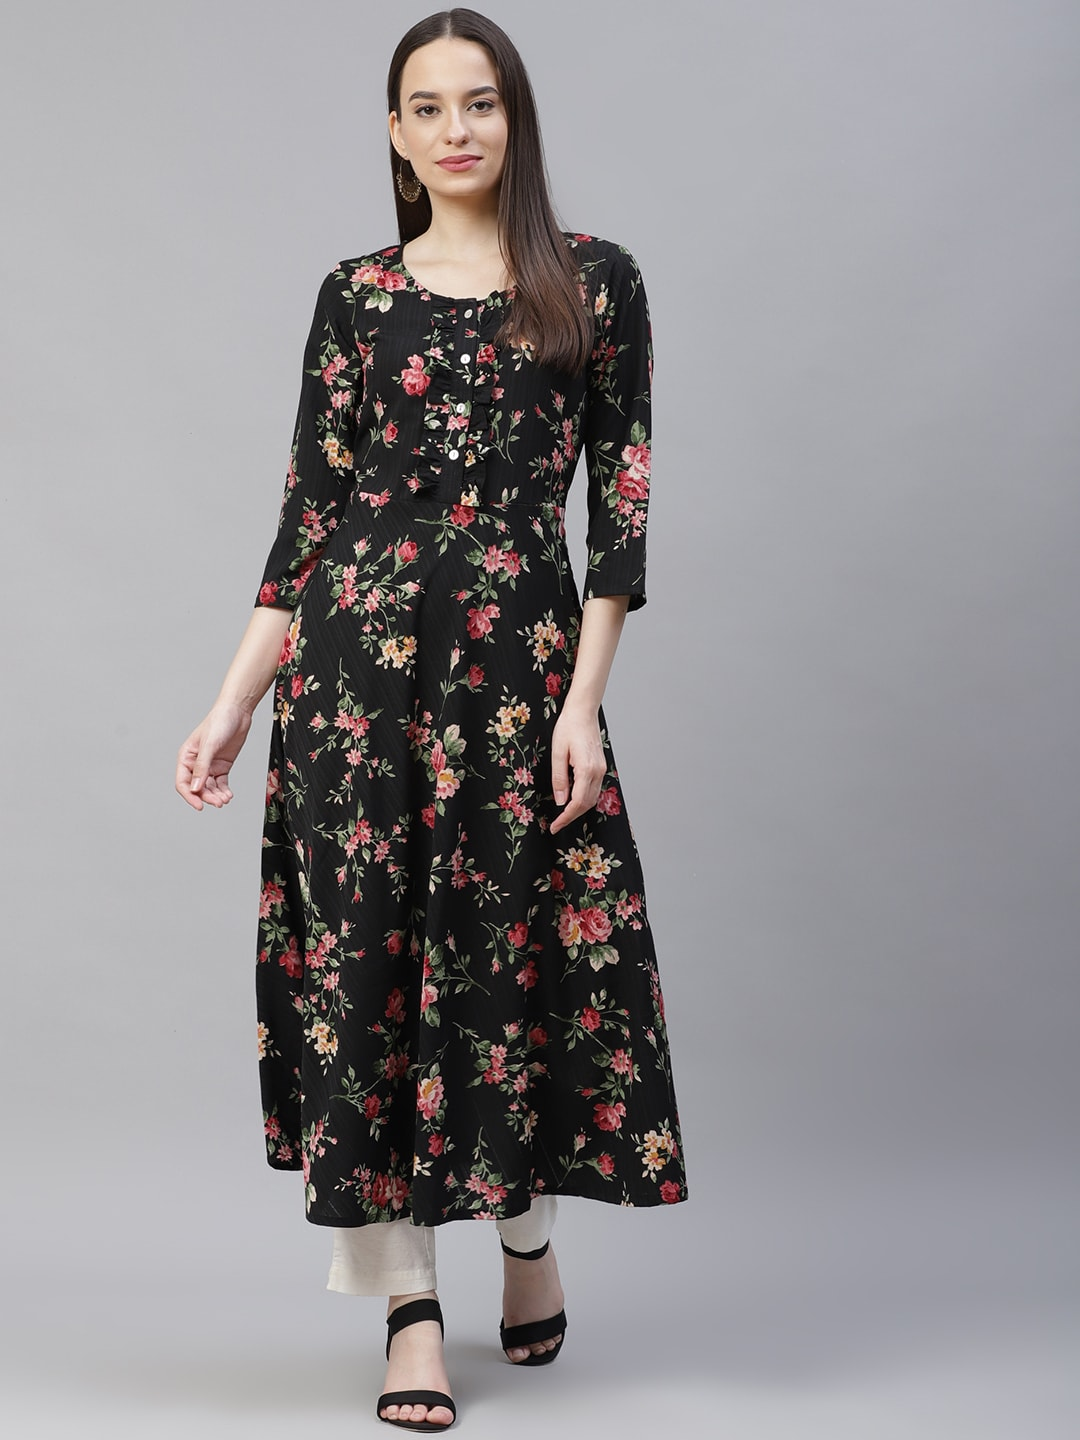


-----------------------------------
Similar product
-----------------------------------
I found a suitable black Anarkali Kurta that fits your criteria. It's the Ahalyaa Women Black Star Foil Print Angrakha Anarkali Kurta. This kurta features a black foil print with a shawl neck, three-quarter sleeves, and a flared hem. It's made of net fabric and has an average rating of 4.32. The price is 2934 INR. This kurta is ankle-length and is suitable for festive occasions. The unique quirky print adds a stylish touch to the traditional Anarkali design.

Hey, here's recommended product, specially for you :


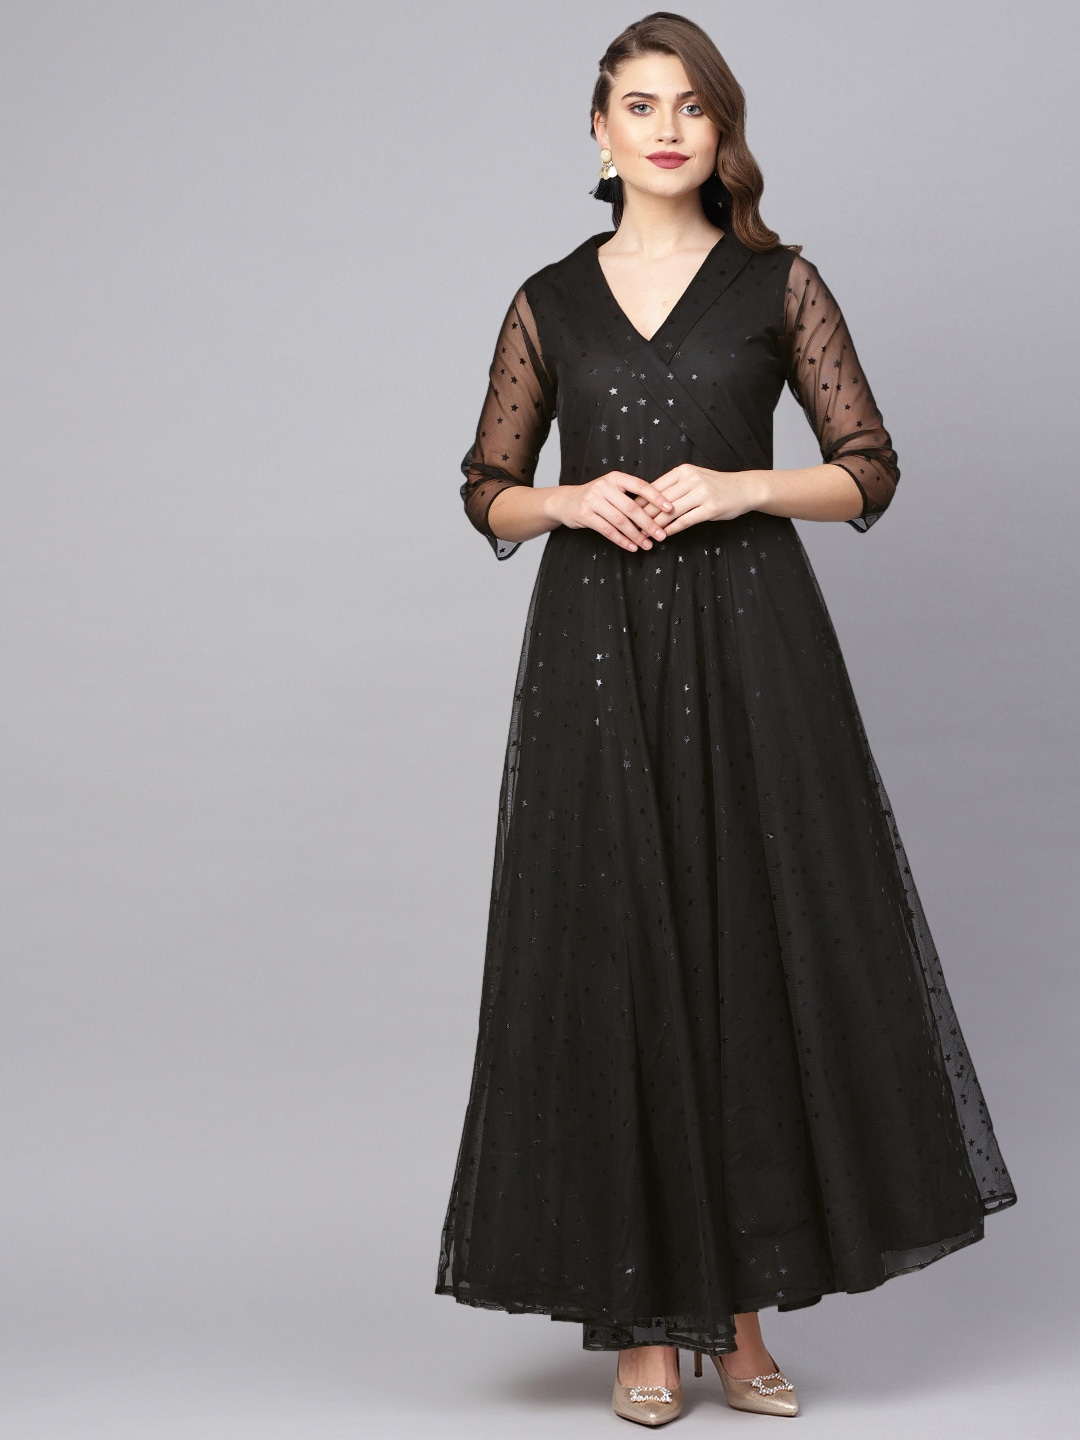

In [135]:
# An example generative search
Generative_Search('Suggest Printed Floral Anarkali Kurta, in black color, with average rating of above 4')

<span style="color: navy;">


## Validate user queries

##### Query 1 : "suggest me Charcoal color jeans"



In [139]:
validate_user_query_1 = "suggest me Charcoal color jeans"

In [140]:
Semantic_Srch_With_Rerank(validate_user_query_1)

Query: suggest me Charcoal color jeans
***********************************

[NOTE] : Not found in cache. Found in main collection.
 
User query :  suggest me Charcoal color jeans


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Metadatas  \
1  {'p_id': 17398354}   
4  {'p_id': 17226246}   
5  {'p_id': 14954878}   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Documents  \
1   Name : bebe Women Charcoal Grey Solid Stretchable Jeans\n    Products : Jeans\n    Price : 3099.0\n    Color : Charcoal\n    Brand : bebe \n    Average Rating : 5.00 \n    Product Description : Dark shade, no fade charcoal jeans Regular fit, mid-rise Clean look Stretchable 5 pocket Length: regular Fit: Regular Fit Stretchable Size worn by the model: 28 Waist: 27" Hips: 37" Height: 5'9" 67.59% Cotton, 29.53% Polyester, 2.88% Elastane Machine wash\n    Product Attributes : {'Add-Ons': 'NA', 'Body or Garment Size': 'To-Fit Denotes Body Measurements in', 'Brand Fit Name': 'NA', 'Character': 'NA', 'Closure': 'Button and Zip', 'Distress': 'Clean Look', 'Effects': 'None', 'Fabric': 'Cotton', 'Fabric 2': 'Polyester', 'Fabric 3': 'Elastane', 'Fade': 'No Fade', 'Features': 'NA', 'Fit': 'Regular Fit', 'Length': 'Regular', 'Main Trend': 'NA', 'Number of Pockets': '5', 'Occasion': 'Casual', 'Reversible': 'No', 'Shade': 'Dark', 'Stretch': 'Stretchable', 'Sustainable': 'Regular', 'Type of Distress': 'NA', 'Waist Rise': 'Mid-Rise', 'Waistband': 'With belt loops', 'Wash Care': 'Machine Wash'}   
4                                              Name : SHOWOFF Women Charcoal Grey Wide Leg High-Rise Clean Look Jeans\n    Products : Jeans\n    Price : 3440.0\n    Color : Charcoal\n    Brand : SHOWOFF \n    Average Rating : 4.00 \n    Product Description : Dark shade, no fade charcoal jeans Wide leg, high-rise Clean look Non stretchable 5 pocket Length: cropped Cotton Dry Clean Fit: Wide Leg Non Stretchable The model (height 5'8) is wearing a size 28\n    Product Attributes : {'Add-Ons': 'NA', 'Body or Garment Size': 'To-Fit Denotes Body Measurements in', 'Brand Fit Name': 'NA', 'Character': 'NA', 'Closure': 'Button and Zip', 'Distress': 'Clean Look', 'Effects': 'None', 'Fabric': 'Cotton', 'Fabric 2': 'NA', 'Fabric 3': 'NA', 'Fade': 'No Fade', 'Features': 'NA', 'Fit': 'Wide Leg', 'Length': 'Cropped', 'Main Trend': 'NA', 'Number of Pockets': '5', 'Occasion': 'Casual', 'Reversible': 'No', 'Shade': 'Dark', 'Stretch': 'Non Stretchable', 'Sustainable': 'Regular', 'Type of Distress': 'Cat Scratches', 'Waist Rise': 'High-Rise', 'Waistband': 'With belt loops', 'Wash Care': 'Dry Clean'}   
5  Name : Roadster Women Charcoal Mid-Rise Straight Fit Jeans\n    Products : Jeans\n    Price : 2599.0\n    Color : Charcoal\n    Brand : Roadster \n    Average Rating : 3.79 \n    Product Description : Dark shade, no fade charcoal jeans Straight fit, mid-rise Clean look Non stretchable 6 pocket Length: regular Fit: Straight Fit Non Stretchable The model (height 5'8) is wearing a size 2893% Cotton 6% Polyester 1% Elastane Machine wash\n    Product Attributes : {'Add-Ons': 'NA', 'Body or Garment Size': 'To-Fit Denotes Body Measurements in', 'Brand Fit Name': 'NA', 'Character': 'NA', 'Closure': 'Button an

Query: suggest me Charcoal color jeans
***********************************

[NOTE] : Found in cache!
 
User query :  suggest me Charcoal color jeans


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


-----------------------------------
Top product
-----------------------------------
Charcoal is a classic color choice for jeans as it offers a versatile and sophisticated look. The "bebe Women Charcoal Grey Solid Stretchable Jeans" are a great option for those looking for a dark shade with no fade. These jeans feature a regular fit, mid-rise design with a clean look and stretchable fabric. They come with 5 pockets and are of regular length.

The fabric composition includes 67.59% Cotton, 29.53% Polyester, and 2.88% Elastane, making them comfortable to wear. These jeans are machine washable for easy maintenance. The waist rise is mid-rise, and they have a waist size of 27" and hip size of 37".

Overall, these charcoal grey jeans from bebe are not only stylish but also practical and suitable for casual occasions. The detailed product attributes ensure a good fit and quality. You can purchase these jeans for INR 3099.00.

Hey, here's recommended product, specially for you :


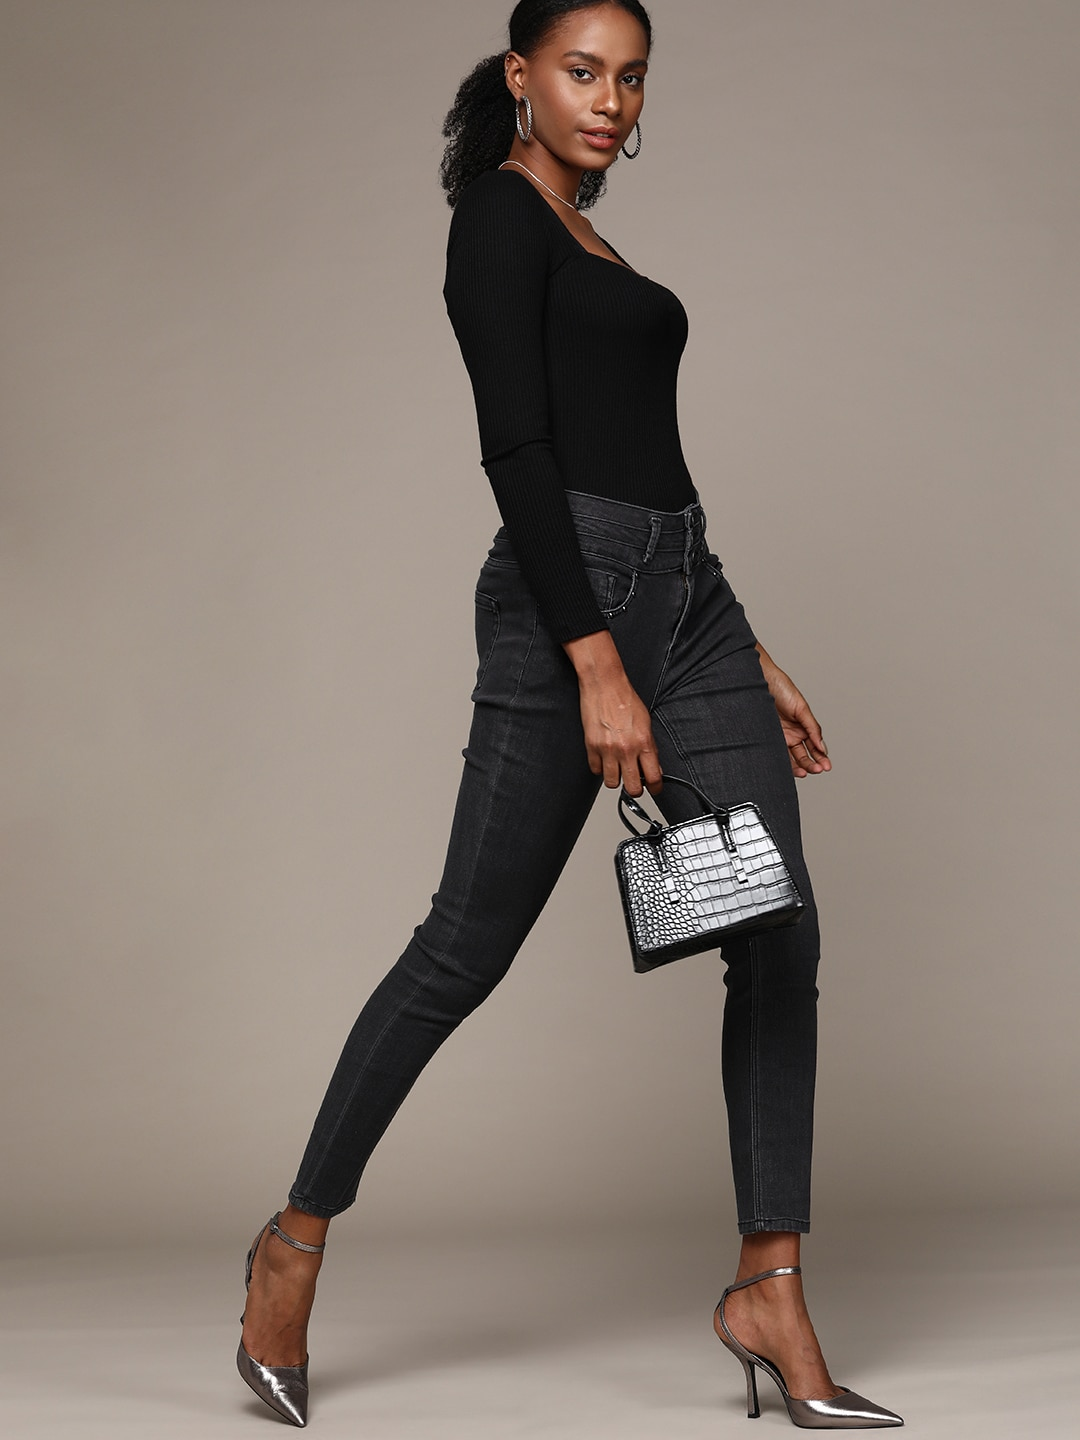


-----------------------------------
Similar product
-----------------------------------
These SHOWOFF Women Charcoal Grey Wide Leg High-Rise Clean Look Jeans are an ideal choice for those looking for charcoal color jeans. They come in a dark shade with no fade, offering a clean look perfect for casual occasions. 

These non-stretchable jeans feature a wide leg, high-rise design with a cropped length. They are made of cotton and require dry cleaning for maintenance. The waistband comes with belt loops, and the closure is a button and zip style.

With five pockets for added functionality, these jeans provide both style and practicality. The model in the description is 5'8 tall and is wearing a size 28.

These jeans are priced at INR 3440.0 and have an average rating of 4.00, ensuring a quality product that meets both style and comfort needs.

Hey, here's recommended product, specially for you :


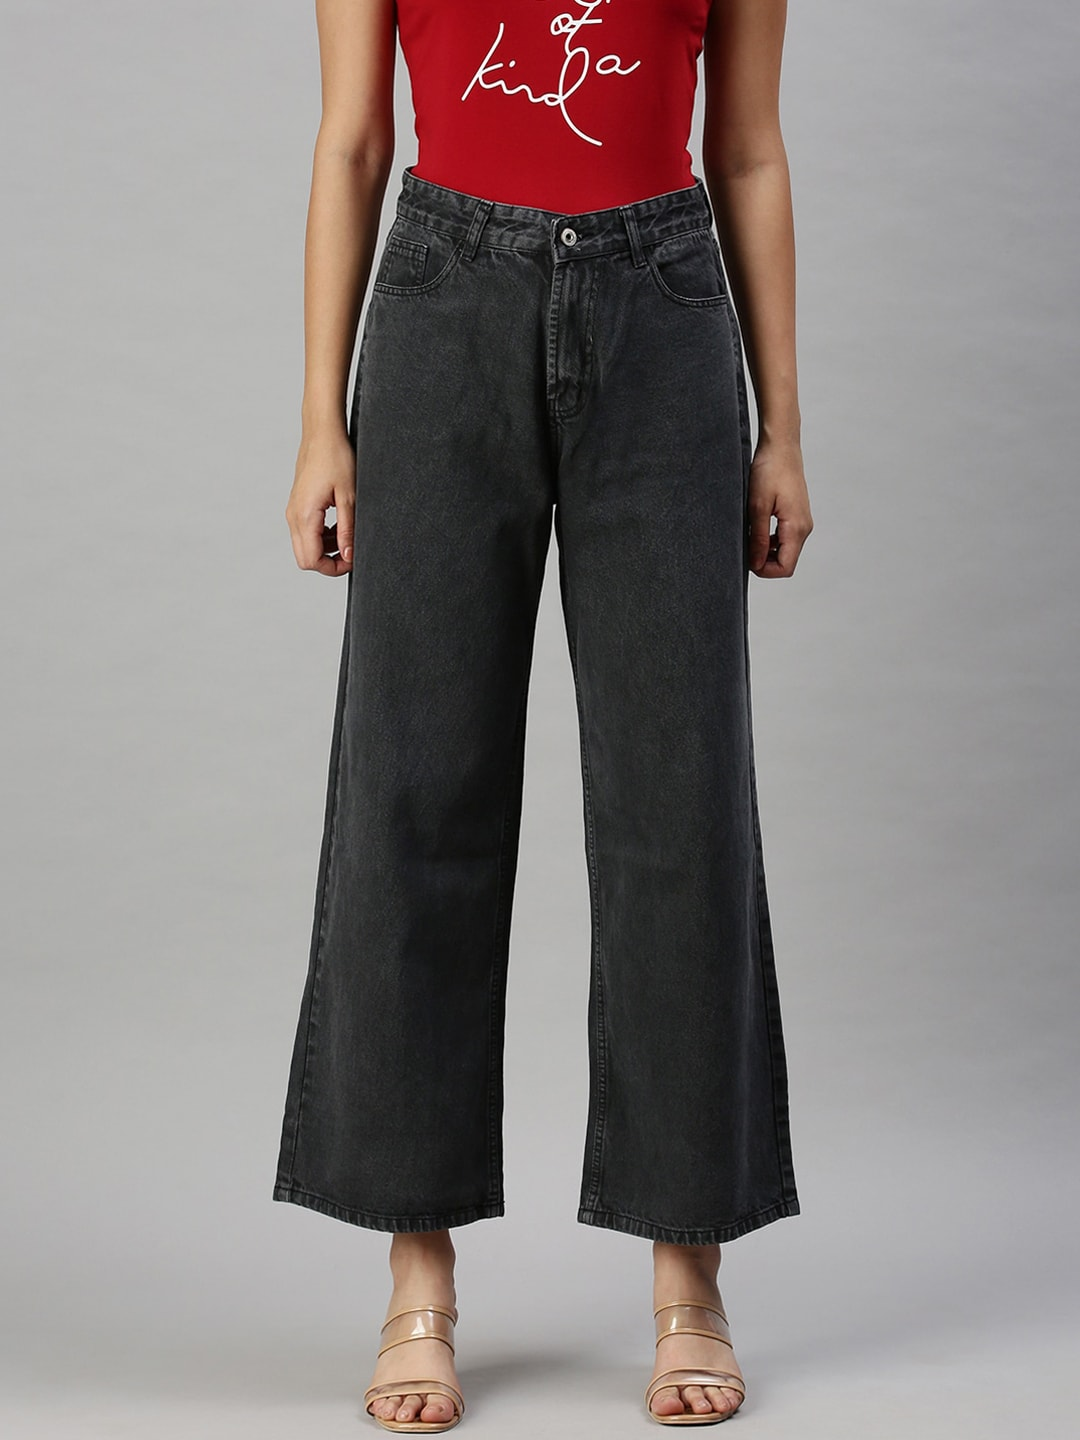


-----------------------------------
Similar product
-----------------------------------
These Roadster Women Charcoal Mid-Rise Straight Fit Jeans are a perfect choice for you. The dark shade with no fade gives them a timeless appeal. They feature a straight fit, mid-rise design, and a clean look, making them versatile for various occasions. Made with 93% Cotton, 6% Polyester, and 1% Elastane, these jeans provide both comfort and style. Additionally, they come with 6 pockets and are non-stretchable. The model is 5'8 and wearing a size 28. You can pair them with your favorite tops for a chic look. Price: INR 2599.

Hey, here's recommended product, specially for you :


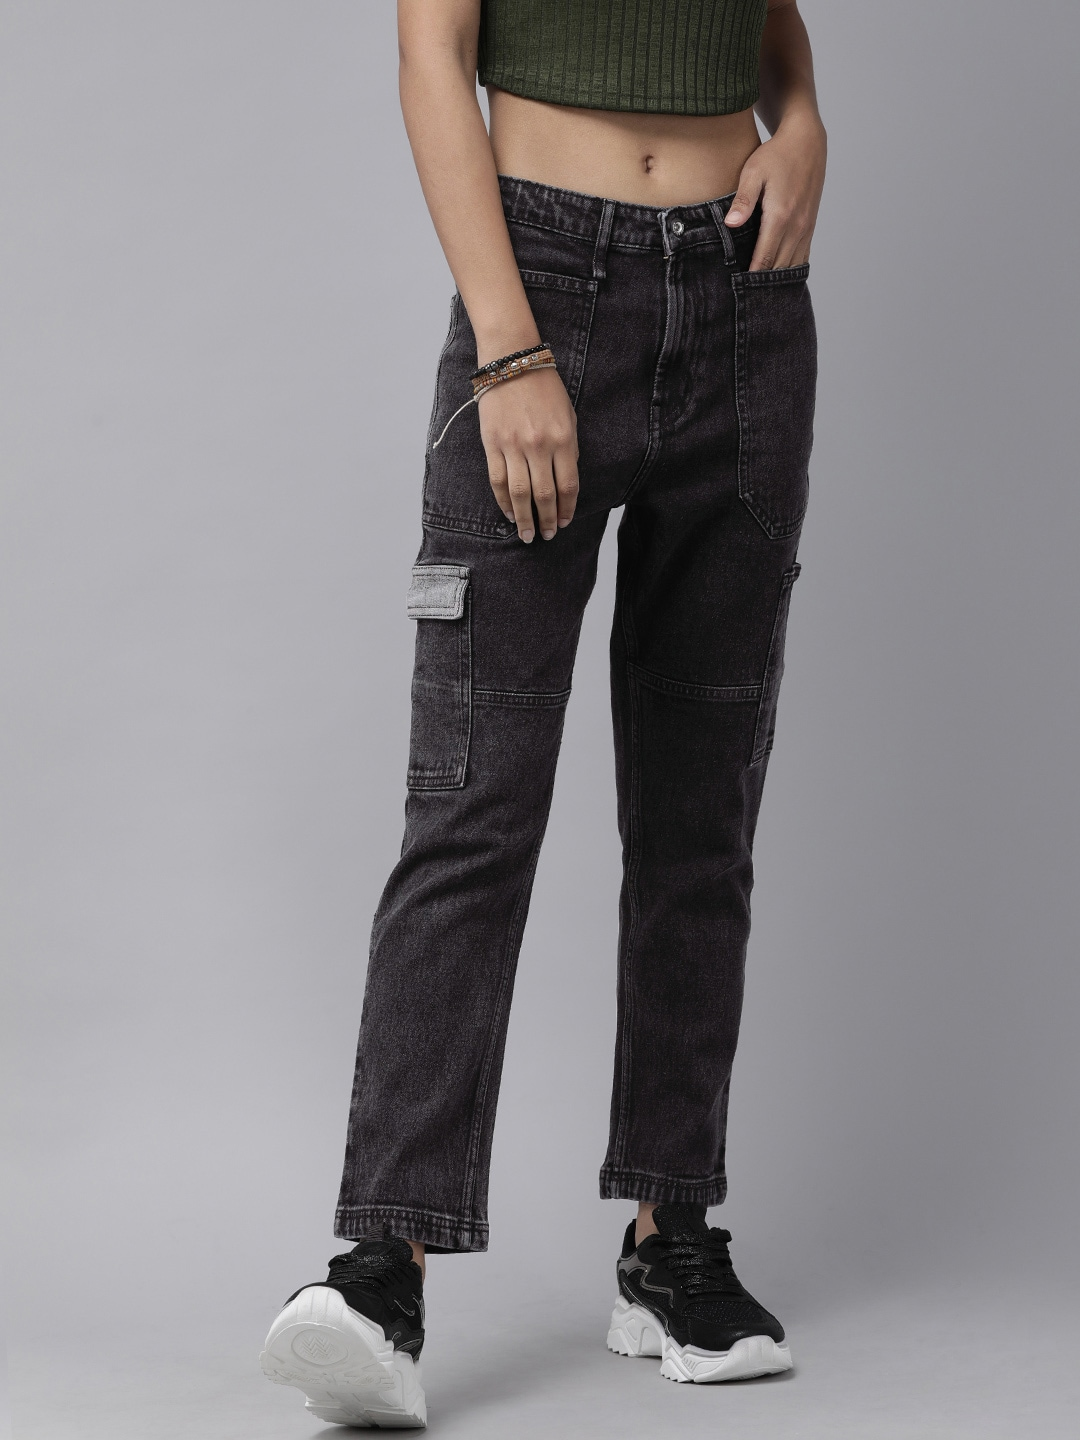

In [141]:
Generative_Search(validate_user_query_1)

<span style="color: navy;">

### Test result Observation    
    
-  Semantic_Srch_With_Rerank has recommended right product
-  Generative search has expressed same info in natural langauge format
    

<span style="color: navy;">


## Validate user queries

##### Query 2 : "suggest me Maroon color Kurta with rating above 4 with price above 1500 inr"

In [146]:
validate_user_query_2 = "suggest me Maroon color Kurta with rating above 4 with price above 1500 inr"

In [147]:
Semantic_Srch_With_Rerank(validate_user_query_2)


Query: suggest me Maroon color Kurta with rating above 4 with price above 1500 inr
***********************************

[NOTE] : Not found in cache. Found in main collection.
 
User query :  suggest me Maroon color Kurta with rating above 4 with price above 1500 inr


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Metadatas  \
2  {'p_id': 11494074}   
1  {'p_id': 15677914}   
5  {'p_id': 12989830}   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Documents  \
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             Name : Varanga Women Maroon Embellished Straight Kurta\n    Products : Kurta\n    Price : 2699.0\n    Color : Maroon\n    Brand : Varanga \n    Average Rating : 4.13 \n    Product Description : Maroon embellished straight kurta, has a round neck, three-quarter sleeves, straight hem, and side slitsThe model (height 5'8") is wearing a size SMaterial: Art Silk Dry Clean\n    Product Attributes : {'Body Shape ID': '424', 'Body or Garment Size': 'To-Fit Denotes Body Measurements in', 'Colour Family': 'Earthy', 'Design Styling': 'Regular', 'Fabric': 'Art Silk', 'Fabric 2': 'NA', 'Fabric Purity': 'Blended', 'Hemline': 'Straight', 'Length': 'Calf Length', 'Main Trend': 'NA', 'Neck': 'Round Neck', 'Number of Pockets': 'NA', 'Occasion': 'Festive', 'Ornamentation': 'Thread Work', 'Pattern': 'Embellished', 'Print or Pattern Type': 'Solid', 'Shape': 'Straight', 'Sleeve Length': 'Three-Quarter Sleeves', 'Sleeve Styling': 'Regular Sleeves', 'Slit Detail': 'Side Slits', 'Stitch': 'Ready to Wear', 'Sustainable': 'Regular', 'Technique': 'NA', 'Wash Care': 'Dry 

Query: suggest me Maroon color Kurta with rating above 4 with price above 1500 inr
***********************************

[NOTE] : Found in cache!
 
User query :  suggest me Maroon color Kurta with rating above 4 with price above 1500 inr


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


-----------------------------------
Top product
-----------------------------------
I have found a Maroon embellished straight kurta by Varanga with an average rating of 4.13. The price of this kurta is INR 2699, which is above INR 1500 as per your request. The product description includes a round neck, three-quarter sleeves, straight hem, and side slits. It is made of Art Silk material and suitable for dry clean only. The kurta is calf-length and designed for festive occasions with thread work ornamentation.

Hey, here's recommended product, specially for you :


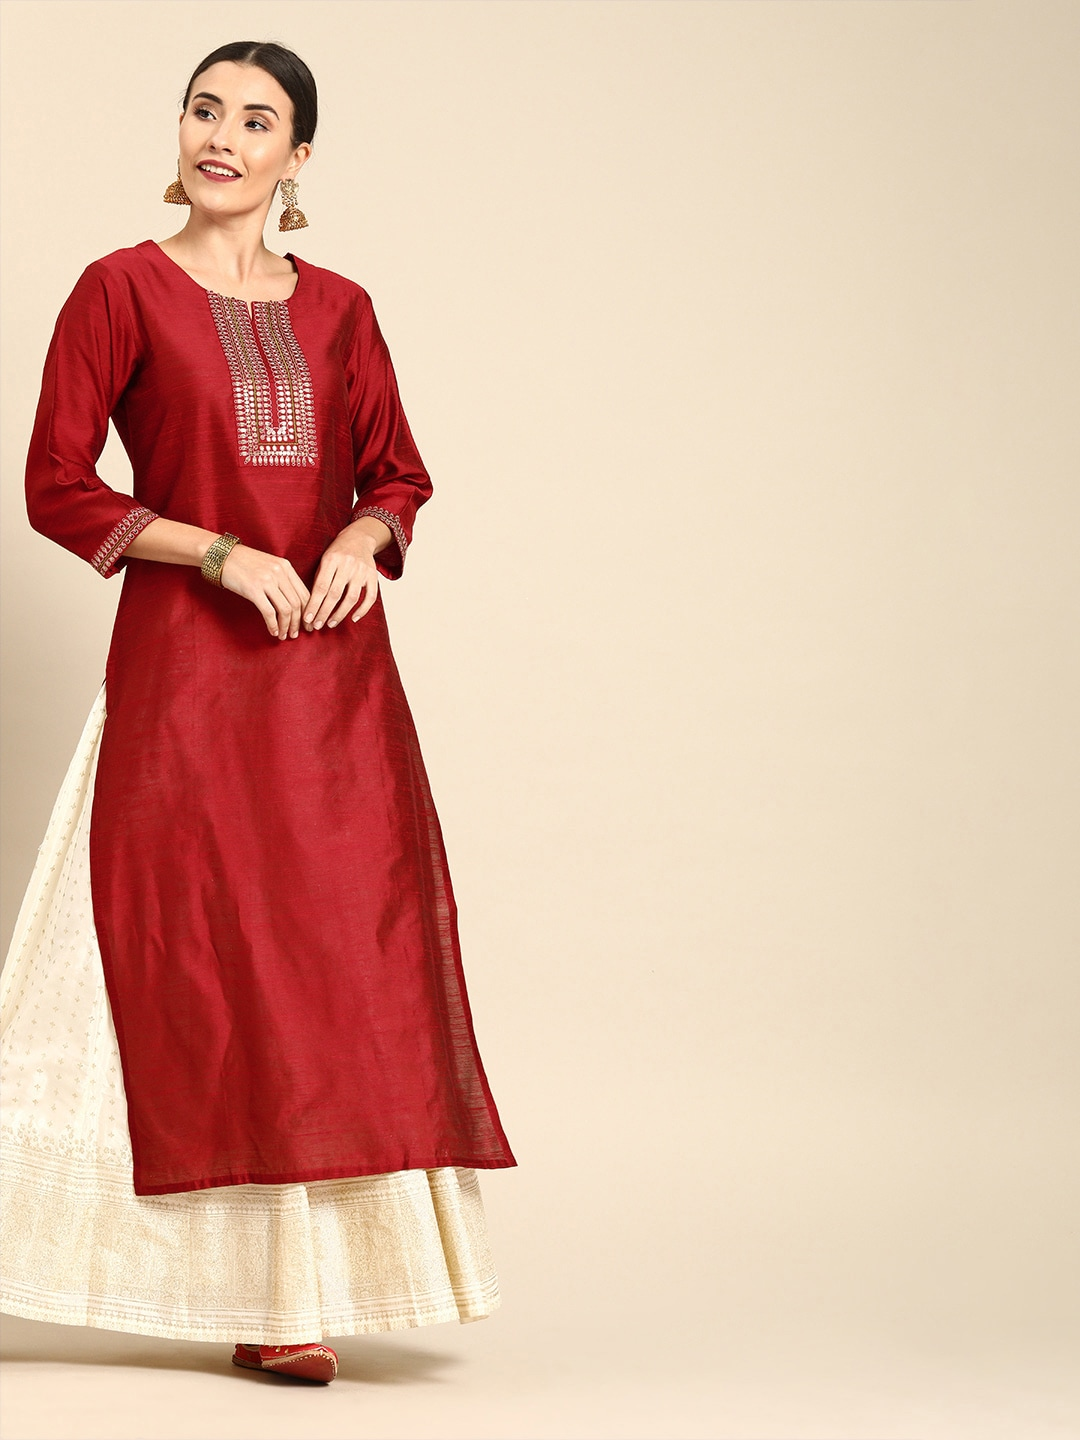


-----------------------------------
Similar product
-----------------------------------
I recommend the Fabindia Women Maroon Ethnic Motifs Print Regular Pure Cotton Kurta with Trousers priced at INR 3599. It has a high average rating of 4.73, well above the threshold you specified. The Kurta features ethnic motifs print, three-quarter regular sleeves, and comes with solid trousers. The fabric is pure cotton, and the design includes a round neck and a calf-length straight hem. For care, it is recommended to hand wash the product separately for the first few washes due to traditional dyeing processes.

Hey, here's recommended product, specially for you :


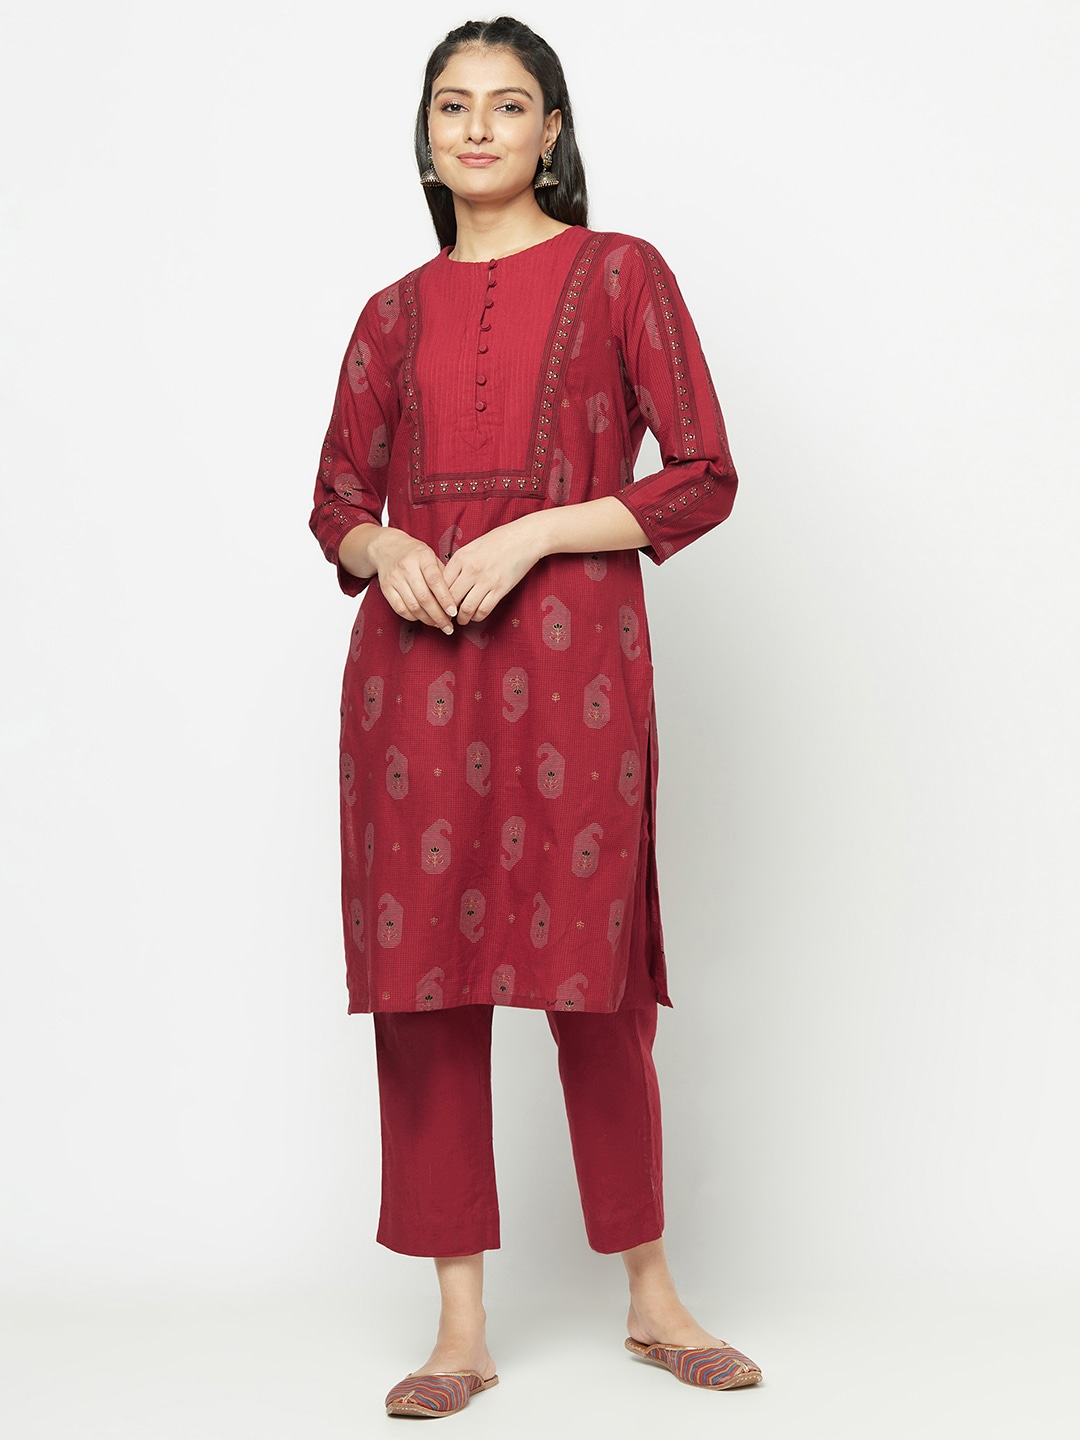


-----------------------------------
Similar product
-----------------------------------
The Maroon & Golden Bandhani Print Kurta with Palazzos from mokshi is an excellent choice for you. This set has an average rating of 4.24, which exceeds 4 as you requested. Priced at INR 2799, it is above your price range of 1500 INR. The kurta features a unique bandhani print with a round neck and three-quarter sleeves, while the palazzos have an elasticated waistband for comfort. This festive set is made of Viscose Rayon fabric and requires dry cleaning for maintenance.

Hey, here's recommended product, specially for you :


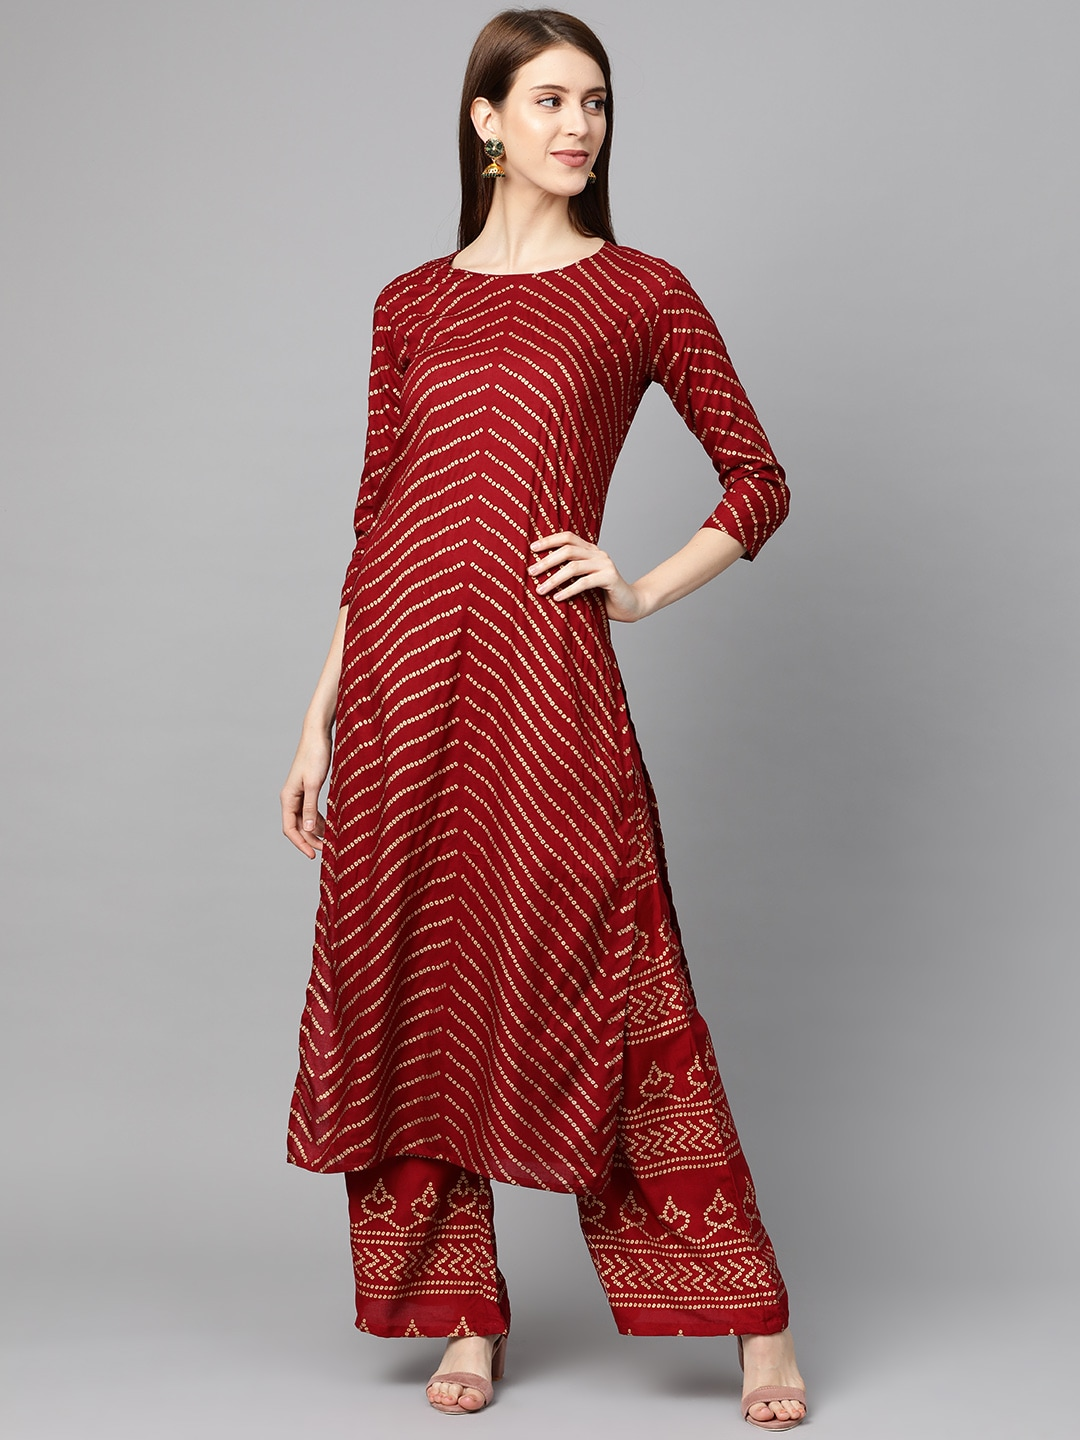

In [148]:
Generative_Search(validate_user_query_2)


<span style="color: navy;">

### Test result Observation    
    
-  Semantic_Srch_With_Rerank has recommended right product
-  Generative search has expressed same info in natural langauge format
   

<span style="color: navy;">


## Validate user queries

##### Query 3 : "suggest me Blue top with rating above 4 with price below 2500 inr"

In [149]:
validate_user_query_3 = "suggest me Blue top with rating above 4 with price below 2500 inr"

In [150]:
Semantic_Srch_With_Rerank(validate_user_query_3)


Query: suggest me Blue top with rating above 4 with price below 2500 inr
***********************************

[NOTE] : Not found in cache. Found in main collection.
 
User query :  suggest me Blue top with rating above 4 with price below 2500 inr


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Metadatas  \
7  {'p_id': 15102850}   
5  {'p_id': 13778078}   
2  {'p_id': 17445656}   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            Documents  \
7                                                                                                                                                      Name : MANGO Blue Regular Top\n    Products : Top\n    Price : 1790.0\n    Color : Blue\n    Brand : MANGO \n    Average Rating : 4.04 \n    Product Description : Blue regular top Solid V-neck, short, flutter sleeves Ruffled Knitted Button closure 52% Polyester,48% cotton Machine washThe model (height 5'8) is wearing a size S\n    Product Attributes : {'Body Shape ID': '443,333,324,424', 'Body or Garment Size': 'To-Fit Denotes Body Measurements in', 'Center Front Open': 'No', 'Character': 'NA', 'Closure': 'Button', 'Fabric': 'Polyester', 'Fabric Type': 'NA', 'Length': 'Regular', 'Lining': 'NA', 'Main Trend': 'Lace Frills Bows and Ruffles', 'Multipack Set': 'NA', 'Neck': 'V-Neck', 'Occasion': 'Casual', 'Pattern': 'Solid', 'Print or Pattern Type': 'Solid', 'Sleeve Length': 'Short Sleeves', 'Sleeve Styling': 'Flutter Sleeves', 'Surface Styling': 'NA', 'Sustainable': 'Regular', 'Transparency': 'Opaque', 'Type': 'Regular', 'Wash Care': 'Machine Wash', 'Weave Type': 'Knitted', 'taxMaterial': 'NA'}   
5  Name : DressBerry Navy Blue Ribbed High Neck Top\n    Products : Top\n    Price : 1499.0\n    Color : Navy Blue\n    Brand : DressBerry \n    Average Rating : 4.33 \n    Product Description : Navy blue regular top Ribbed&nbsp; High neck short, regular sleeves Knitted Zip closure The model (height 5'8) is wearing a size S65% polyester, 33% viscose, 2% Lycra Machine wash\n    Product Attributes : {'Body Shape ID': '333', 'Care for me': 'Follow the fabric care label. Warm machine wash is recommended.\r\nCan be tumble dried in a cool setting.\r\nPrevent static build-up by drying while damp. \r\nUse low heat to iron.', 'Center Front Open': 'No', 'Character': 'NA', 'Closure': 'Zip', 'Fabric': 'Polyester', 'Fabric Type': 'NA', 'Length': 'Regular', 'Lining': 'NA', 'Main Trend': 'Nautical', 'Multipack Set': 'NA', 'Neck': 'High Neck', 'Occasion': 'Casual', 'Pattern': 'Solid', 'Print or Pattern Type': 'Solid', 'Sleeve Length': 'Short Sleeves', 'Sleeve Styling': 'Regular Sleeves', 'Surface Styling': 'NA', 'Sustainable': 'Regular', 'Transparency': 'Opaque', 'Type': 'Regular', 'Wash Care': 'Machine Wash', 'Weave Type': 'Knitted', 'taxMaterial': 'NA'}   
2                                                                                Name : Vishudh Blue Floral Print Peplum Top\n    Products : Top\n    Price : 1299.0\n    Color : Blue\n    Brand : Vishudh \n    Average Rating : 4.28 \n    Product Description : Blue regular peplum top Floral print Round neck, three-quarter, regular sleeves Gathered or pleated detail Woven 50% Cotton 50% Polyester Machine washThe model (height 

Query: suggest me Blue top with rating above 4 with price below 2500 inr
***********************************

[NOTE] : Found in cache!
 
User query :  suggest me Blue top with rating above 4 with price below 2500 inr


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


-----------------------------------
Top product
-----------------------------------
I have found a Blue top that matches your criteria. The MANGO Blue Regular Top is priced at 1790 INR, has a rating of 4.04, and falls within your budget requirement. It features a solid V-neck design with short flutter sleeves and a ruffled knitted texture. The top is made of 52% Polyester and 48% cotton, making it comfortable and easy to care for with a machine wash. The closure is done with buttons, and the overall style is casual, suitable for various occasions.

Hey, here's recommended product, specially for you :


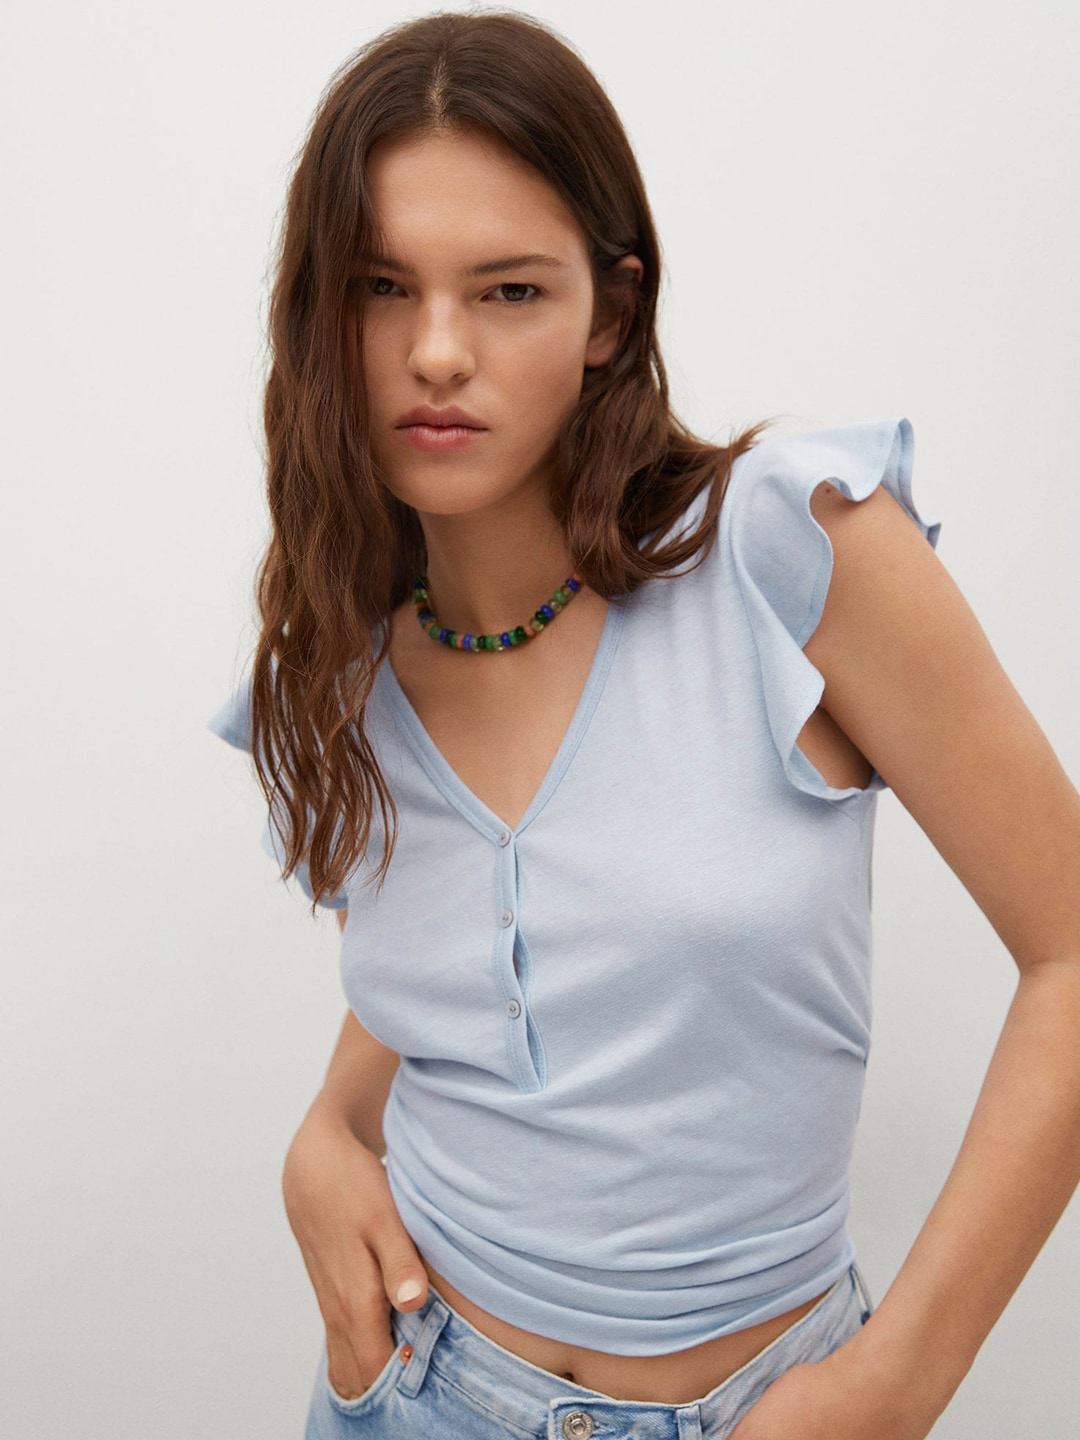


-----------------------------------
Similar product
-----------------------------------
I found a Navy Blue Ribbed High Neck Top by DressBerry priced at INR 1499 with an average rating of 4.33. It fits your criteria for a Blue top with a rating above 4 and a price below 2500 INR. The top features a high neck, short sleeves, and a zip closure. It is made of 65% polyester, 33% viscose, and 2% Lycra. The fabric care instructions recommend machine wash.

Hey, here's recommended product, specially for you :


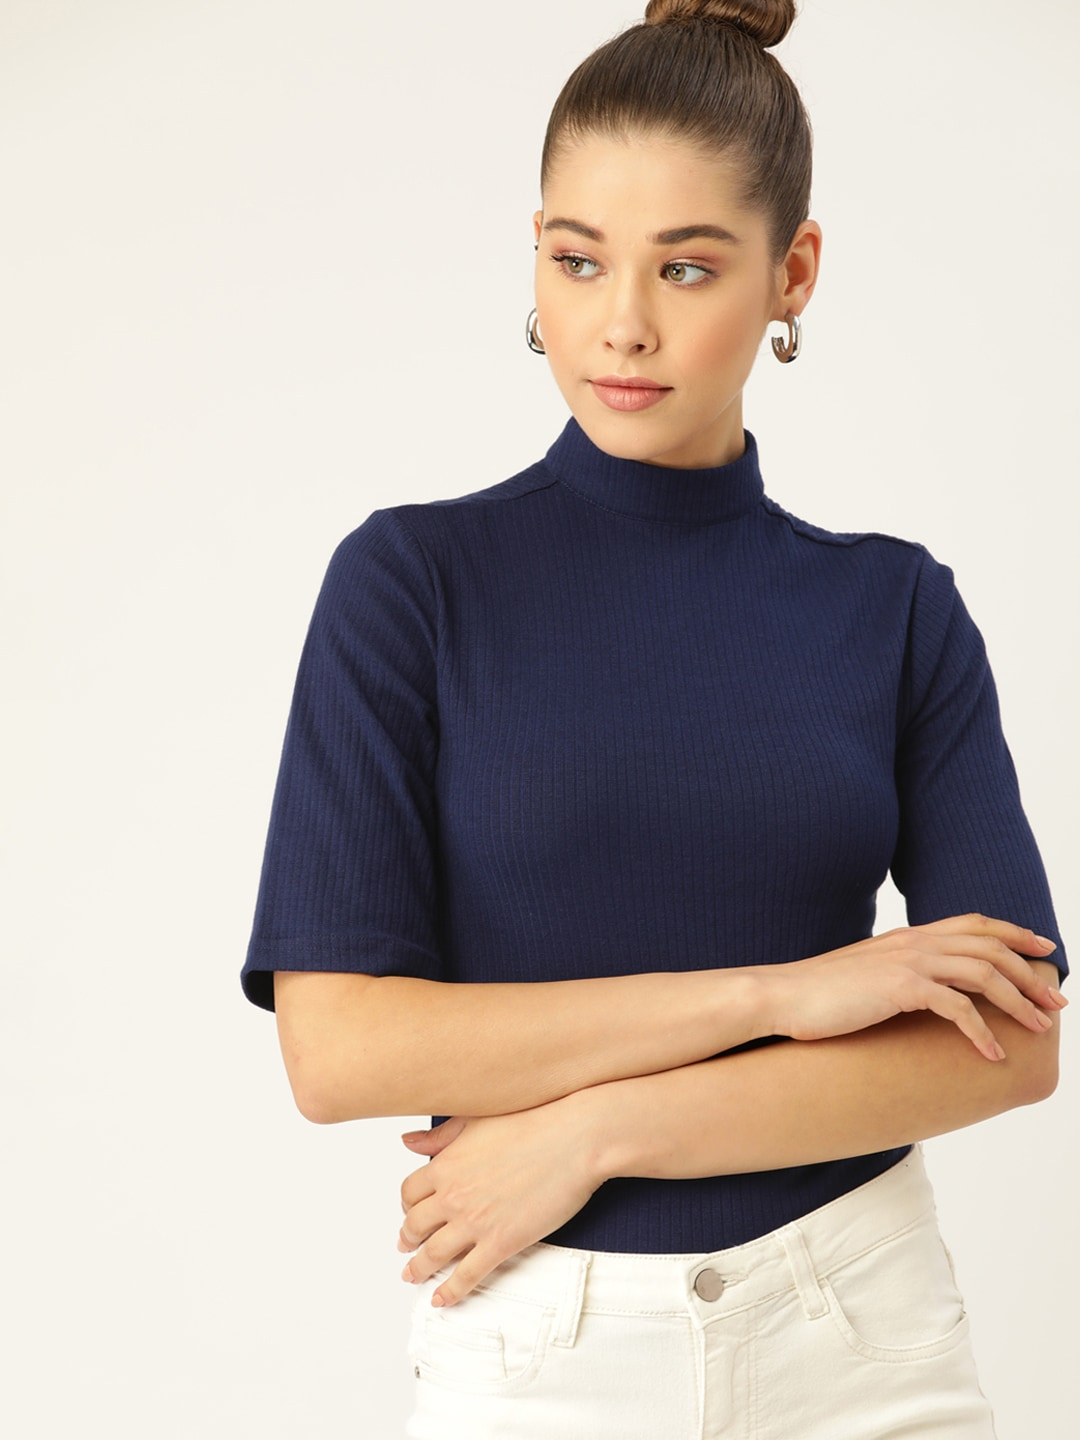


-----------------------------------
Similar product
-----------------------------------
I found a Blue Floral Print Peplum Top by Vishudh priced at 1299 INR with an average rating of 4.28, meeting your criteria of a Blue top with a rating above 4 and a price below 2500 INR. The top features a round neck, three-quarter sleeves, and a gathered or pleated detail. It is made of a cotton-polyester blend and is recommended for machine wash.

Hey, here's recommended product, specially for you :


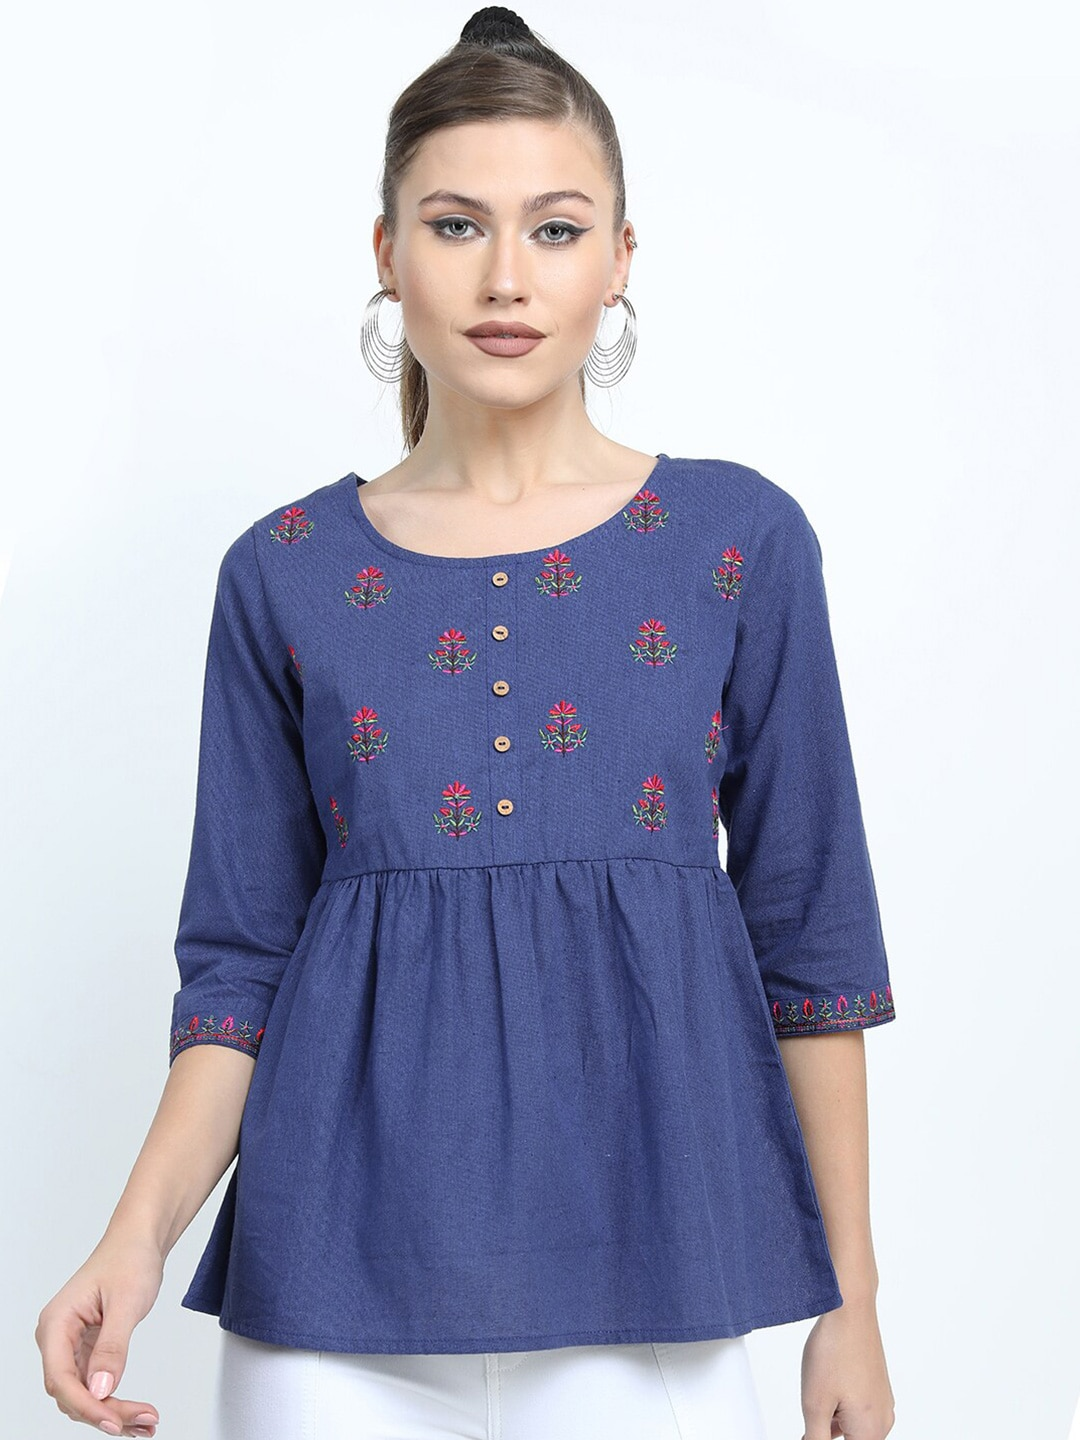

In [151]:
Generative_Search(validate_user_query_3)


<span style="color: navy;">

### Test result Observation    
    
-  Semantic_Srch_With_Rerank has recommended right product
-  Generative search has expressed same info in natural langauge format
   
   

<span style="color: navy;">

### Final Observation and notes  
    
-  The program is working as expected and able to cater to user queries. 
-  The images are extracted directly from Kaggle server and pid matched as per user query. 
   

<span style="color: navy;">

# Exploration Zone
    
- Try out / explore 
    


In [ ]:
Generative_Search("Pink top above 2500 INR")


In [ ]:
Generative_Search("Floral Top ")